In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor,\
    AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader
import optuna

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history, AdaBoost_creator 
from library.XGBoost import XGBoost_creator
from library.LightGBM import LightGBM_creator
from library.CatBoost import CatBoost_creator
from library.RandomForest import RandomForest_creator
from library.ExtraTrees import ExtraTrees_creator
from library.NeuralNetwork import RunhistSet, NeuralNetworkC, trainingC
from library.StackingCV_Scheme3 import stratified_data, runall_LR, runall_RidgeR, stackingCV_creator, vif, \
    correlation_plot, rank_importance

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

Using cpu device.


'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### Load Hyperparameters

In [2]:
# load hyperparameters of all base learners in a dictionary
def load_hyper(num_set, date, model_list, iter_list, filename, mode, TPE_multi) :
    
    sampler = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
    allset_dict = {}
    for j in range(1, num_set) :
        
        model_dict = {}
        for i, model in enumerate(model_list) :

            with open(f'hyperparameter/{date}/{filename}_{model}{mode}_{sampler}_{iter_list[i]}.data', 'rb') as f:
                temp_dict = pickle.load(f)
                model_dict[model] = temp_dict[f'set{j}']
                
        allset_dict[f'set{j}'] = model_dict
        
    return allset_dict

### Transform Data by Base Learners

In [13]:
# input training data to the base learners and output the outcome
def transform_train(train_data, mode, base_param, cv, add_origin = False):
    
    set_name = list(base_param.keys())
    model_list = list(base_param[set_name[0]].keys())
    set_dict = {}
    for i in tqdm(set_name):

        train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train_data[i], cv = cv)
        all_cv = pd.DataFrame()
        for j in tqdm(range(cv)):

            model_predict = valid_x_dict[j].copy().reset_index(drop = True) if add_origin else pd.DataFrame()
            if mode == 'C':          
                if 'NeuralNetwork' in model_list:
                    temp_train = RunhistSet(train_x_dict[j], train_y_dict[j])
                    temp_valid = RunhistSet(valid_x_dict[j], valid_y_dict[j])
                    train_loader = DataLoader(temp_train, 
                                              batch_size = base_param[i]['NeuralNetwork']['batch_size'], 
                                              shuffle = True)
                    valid_loader = DataLoader(temp_valid, batch_size = len(valid_x_dict[j]), shuffle = False)
                    nn_model = NeuralNetworkC(dim = train_x_dict[j].shape[1])
                    optimizer = torch.optim.Adam(nn_model.parameters(), 
                                                 lr = base_param[i]['NeuralNetwork']['learning_rate'], 
                                                 weight_decay = base_param[i]['NeuralNetwork']['weight_decay'])
                    criterion = nn.CrossEntropyLoss(
                        weight = torch.tensor([1-base_param[i]['NeuralNetwork']['bad_weight'], 
                                               base_param[i]['NeuralNetwork']['bad_weight']])).to('cpu')
                    network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 100, 
                                              early_stop = 10)
                    for x, y in valid_loader:
                        output = network(x)
                        predict_y = output.data[:, 1]
                    predict = pd.DataFrame({'N': predict_y.numpy()})
                    model_predict = pd.concat([model_predict, predict], axis = 1)
                
                if 'XGBoost' in model_list:                     
                    clf = XGBClassifier(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:                        
                    clf = LGBMClassifier(**base_param[i]['LightGBM'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    clf = CatBoostClassifier(**base_param[i]['CatBoost'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeClassifier(
                            max_depth = base_param[i]['AdaBoost']['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    clf = AdaBoostClassifier(**boost_param)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    clf = RandomForestClassifier(**base_param[i]['RandomForest'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    clf = ExtraTreesClassifier(**base_param[i]['ExtraTrees'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            elif mode == 'R':

                if 'XGBoost' in model_list:
                    reg = XGBRegressor(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:
                    reg = LGBMRegressor(**base_param[i]['LightGBM'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    reg = CatBoostRegressor(**base_param[i]['CatBoost'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeRegressor(
                            max_depth = base_param[i]['AdaBoost']['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    reg = AdaBoostRegressor(**boost_param)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    reg = RandomForestRegressor(**base_param[i]['RandomForest'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    reg = ExtraTreesRegressor(**base_param[i]['ExtraTrees'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            test_label = valid_y_dict[j].reset_index(drop = True)
            done_cv = pd.concat([model_predict, test_label], axis = 1)
            all_cv = pd.concat([all_cv, done_cv], axis = 0)

        set_dict[i] = all_cv
    
    return set_dict


# input testing data to the base learners and output the outcome
def transform_test(train_data, test_data, mode, base_param, add_origin = False):
    
    set_name = list(base_param.keys())
    model_list = list(base_param[set_name[0]].keys())
    test_dict = {}
    for i in tqdm(set_name):
        
        train_x, train_y, test_x, test_y = label_divide(train_data[i], test_data, train_only = False)
        model_predict = test_x.copy().reset_index(drop = True) if add_origin else pd.DataFrame()
        if mode == 'C':

            if 'NeuralNetwork' in model_list:
                temp_train = RunhistSet(train_x, train_y)
                temp_test = RunhistSet(test_x, test_y)
                train_loader = DataLoader(temp_train, 
                                          batch_size = base_param[i]['NeuralNetwork']['batch_size'], 
                                          shuffle = True)
                test_loader = DataLoader(temp_test, batch_size = len(test_x), shuffle = False)
                nn_model = NeuralNetworkC(dim = train_x.shape[1])
                optimizer = torch.optim.Adam(nn_model.parameters(), 
                                             lr = base_param[i]['NeuralNetwork']['learning_rate'], 
                                             weight_decay = base_param[i]['NeuralNetwork']['weight_decay'])
                criterion = nn.CrossEntropyLoss(
                    weight = torch.tensor([1-base_param[i]['NeuralNetwork']['bad_weight'], 
                                           base_param[i]['NeuralNetwork']['bad_weight']])).to('cpu')
                network, _, _ = trainingC(nn_model, train_loader, train_loader, optimizer, criterion, epoch = 100, 
                                          early_stop = 10)
                for X, Y in test_loader:
                    X, Y = X.float(), Y.long()
                    output = network(X)
                    predict_y = output.data[:, 1]
                predict = pd.DataFrame({'N': predict_y.numpy()})
                model_predict = pd.concat([model_predict, predict], axis = 1)
            
            if 'XGBoost' in model_list:
                clf = XGBClassifier(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'X': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                clf = LGBMClassifier(**base_param[i]['LightGBM'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'L': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                clf = CatBoostClassifier(**base_param[i]['CatBoost'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'C': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeClassifier(
                        max_depth = base_param[i]['AdaBoost']['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                clf = AdaBoostClassifier(**boost_param)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'A': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                clf = RandomForestClassifier(**base_param[i]['RandomForest'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'R': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                clf = ExtraTreesClassifier(**base_param[i]['ExtraTrees'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'E': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        elif mode == 'R':

            if 'XGBoost' in model_list:
                reg = XGBRegressor(**base_param[i]['XGBoost'], use_label_encoder = False, n_jobs = -1)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'X': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                reg = LGBMRegressor(**base_param[i]['LightGBM'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'L': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                reg = CatBoostRegressor(**base_param[i]['CatBoost'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'C': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeRegressor(
                        max_depth = base_param[i]['AdaBoost']['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param[i]['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                reg = AdaBoostRegressor(**boost_param)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'A': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                reg = RandomForestRegressor(**base_param[i]['RandomForest'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'R': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                reg = ExtraTreesRegressor(**base_param[i]['ExtraTrees'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'E': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        model_done = pd.concat([model_predict, test_y], axis = 1)
        test_dict[i] = model_done
        
    return test_dict

## 

### Load Data

In [4]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1360, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1376, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1369, 88)  balance ratio: 1.02
Dimension of dataset 7 : (1317, 88)  balance ratio: 1.1
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (2224, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2256, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

## Base Learner

In [43]:
##### loading hyperparameters of all base learners #####
hyper_info = {
    'num_set': 10,
    'date': '20220308',
    'model_list': ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest'],
    'iter_list': [25, 25, 25, 20],
    'filename': 'runhist_array_m2m4_m5_3criteria',
    'TPE_multi': False
}

base_paramC = load_hyper(**hyper_info, mode = 'C')

In [ ]:
##### or optimize the datasets of whole by optuna ##### 
target_iter = dict(zip(hyper_info['model_list'], hyper_info['iter_list']))

base_param_allC = optimize_base(train_data = {'all': run_train}, 
                                mode = 'C', 
                                TPE_multi = False, 
                                base_list = hyper_info['model_list'], 
                                iter_dict = target_iter,
                                filename = 'runhist_array_m2m4_m5_3criteria')

### Data Transformation

In [44]:
print('Transform Training Data:')
train_firstC = transform_train(run_train, 
                               mode = 'C', 
                               base_param = base_paramC, 
                               cv = 5)
print('\nTransform Testing Data:')
test_firstC = transform_test(run_train, 
                             run_test, 
                             mode = 'C', 
                             base_param = base_paramC)
train_firstC_x, train_firstC_y = train_set(train_firstC)
test_firstC_x, test_firstC_y = train_set(test_firstC) 

# ignore
train_firstC['set0'] = {}

Transform Training Data:


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4229069	total: 13.9ms	remaining: 6.96s
1:	learn: 0.2810884	total: 26.9ms	remaining: 6.69s
2:	learn: 0.2101397	total: 38.6ms	remaining: 6.39s
3:	learn: 0.1620631	total: 50.8ms	remaining: 6.3s
4:	learn: 0.1370070	total: 61.4ms	remaining: 6.07s
5:	learn: 0.1097869	total: 73.9ms	remaining: 6.08s
6:	learn: 0.0902446	total: 84.7ms	remaining: 5.97s
7:	learn: 0.0828901	total: 92.6ms	remaining: 5.7s
8:	learn: 0.0733084	total: 101ms	remaining: 5.51s
9:	learn: 0.0654629	total: 109ms	remaining: 5.34s
10:	learn: 0.0557770	total: 117ms	remaining: 5.2s
11:	learn: 0.0471718	total: 127ms	remaining: 5.16s
12:	learn: 0.0457928	total: 131ms	remaining: 4.92s
13:	learn: 0.0421087	total: 138ms	remaining: 4.79s
14:	learn: 0.0396713	total: 145ms	remaining: 4.67s
15:	learn: 0.0384181	total: 150ms	remaining: 4.53s
16:	learn: 0.0358020	total: 157ms	remaining: 4.46s
17:	learn: 0.0341002	total: 163ms	remaining: 4.38s
18:	learn: 0.0324202	total: 171ms	remaining: 4.32s
19:	learn: 0.0319240	total: 176ms	re

189:	learn: 0.0051670	total: 924ms	remaining: 1.51s
190:	learn: 0.0051670	total: 928ms	remaining: 1.5s
191:	learn: 0.0051670	total: 932ms	remaining: 1.5s
192:	learn: 0.0051666	total: 936ms	remaining: 1.49s
193:	learn: 0.0051635	total: 940ms	remaining: 1.48s
194:	learn: 0.0051634	total: 944ms	remaining: 1.48s
195:	learn: 0.0051631	total: 948ms	remaining: 1.47s
196:	learn: 0.0051631	total: 952ms	remaining: 1.46s
197:	learn: 0.0051631	total: 955ms	remaining: 1.46s
198:	learn: 0.0051629	total: 959ms	remaining: 1.45s
199:	learn: 0.0051571	total: 963ms	remaining: 1.44s
200:	learn: 0.0051245	total: 967ms	remaining: 1.44s
201:	learn: 0.0050728	total: 971ms	remaining: 1.43s
202:	learn: 0.0050724	total: 975ms	remaining: 1.43s
203:	learn: 0.0050724	total: 979ms	remaining: 1.42s
204:	learn: 0.0050724	total: 982ms	remaining: 1.41s
205:	learn: 0.0050722	total: 986ms	remaining: 1.41s
206:	learn: 0.0050531	total: 990ms	remaining: 1.4s
207:	learn: 0.0050323	total: 995ms	remaining: 1.4s
208:	learn: 0.00

371:	learn: 0.0036247	total: 1.66s	remaining: 570ms
372:	learn: 0.0036247	total: 1.66s	remaining: 565ms
373:	learn: 0.0036247	total: 1.66s	remaining: 561ms
374:	learn: 0.0036247	total: 1.67s	remaining: 556ms
375:	learn: 0.0036246	total: 1.67s	remaining: 552ms
376:	learn: 0.0036246	total: 1.68s	remaining: 547ms
377:	learn: 0.0036246	total: 1.68s	remaining: 542ms
378:	learn: 0.0036246	total: 1.68s	remaining: 538ms
379:	learn: 0.0036245	total: 1.69s	remaining: 533ms
380:	learn: 0.0036242	total: 1.69s	remaining: 529ms
381:	learn: 0.0036240	total: 1.7s	remaining: 524ms
382:	learn: 0.0036239	total: 1.7s	remaining: 519ms
383:	learn: 0.0036189	total: 1.7s	remaining: 515ms
384:	learn: 0.0036188	total: 1.71s	remaining: 510ms
385:	learn: 0.0036188	total: 1.71s	remaining: 506ms
386:	learn: 0.0036188	total: 1.72s	remaining: 501ms
387:	learn: 0.0036187	total: 1.72s	remaining: 497ms
388:	learn: 0.0036187	total: 1.73s	remaining: 492ms
389:	learn: 0.0036186	total: 1.73s	remaining: 488ms
390:	learn: 0.0

57:	learn: 0.0113423	total: 379ms	remaining: 2.89s
58:	learn: 0.0112144	total: 384ms	remaining: 2.87s
59:	learn: 0.0109044	total: 390ms	remaining: 2.86s
60:	learn: 0.0107430	total: 394ms	remaining: 2.83s
61:	learn: 0.0105584	total: 398ms	remaining: 2.81s
62:	learn: 0.0103341	total: 402ms	remaining: 2.79s
63:	learn: 0.0101912	total: 408ms	remaining: 2.78s
64:	learn: 0.0100983	total: 412ms	remaining: 2.75s
65:	learn: 0.0100358	total: 416ms	remaining: 2.73s
66:	learn: 0.0099707	total: 420ms	remaining: 2.71s
67:	learn: 0.0098311	total: 423ms	remaining: 2.69s
68:	learn: 0.0097628	total: 427ms	remaining: 2.67s
69:	learn: 0.0093369	total: 432ms	remaining: 2.65s
70:	learn: 0.0090595	total: 438ms	remaining: 2.64s
71:	learn: 0.0089624	total: 442ms	remaining: 2.63s
72:	learn: 0.0089172	total: 446ms	remaining: 2.61s
73:	learn: 0.0088389	total: 449ms	remaining: 2.58s
74:	learn: 0.0088387	total: 452ms	remaining: 2.56s
75:	learn: 0.0087784	total: 456ms	remaining: 2.54s
76:	learn: 0.0086063	total: 460

233:	learn: 0.0047993	total: 1.1s	remaining: 1.26s
234:	learn: 0.0047993	total: 1.11s	remaining: 1.25s
235:	learn: 0.0047992	total: 1.11s	remaining: 1.25s
236:	learn: 0.0047991	total: 1.12s	remaining: 1.24s
237:	learn: 0.0047990	total: 1.12s	remaining: 1.23s
238:	learn: 0.0047989	total: 1.13s	remaining: 1.23s
239:	learn: 0.0047989	total: 1.13s	remaining: 1.22s
240:	learn: 0.0047989	total: 1.13s	remaining: 1.22s
241:	learn: 0.0047475	total: 1.14s	remaining: 1.21s
242:	learn: 0.0047474	total: 1.14s	remaining: 1.21s
243:	learn: 0.0047322	total: 1.15s	remaining: 1.2s
244:	learn: 0.0047319	total: 1.15s	remaining: 1.2s
245:	learn: 0.0047319	total: 1.15s	remaining: 1.19s
246:	learn: 0.0047319	total: 1.16s	remaining: 1.19s
247:	learn: 0.0047319	total: 1.16s	remaining: 1.18s
248:	learn: 0.0047318	total: 1.16s	remaining: 1.17s
249:	learn: 0.0047318	total: 1.17s	remaining: 1.17s
250:	learn: 0.0047318	total: 1.17s	remaining: 1.16s
251:	learn: 0.0047318	total: 1.18s	remaining: 1.16s
252:	learn: 0.0

423:	learn: 0.0039194	total: 1.84s	remaining: 330ms
424:	learn: 0.0039193	total: 1.84s	remaining: 325ms
425:	learn: 0.0039192	total: 1.85s	remaining: 321ms
426:	learn: 0.0039192	total: 1.85s	remaining: 317ms
427:	learn: 0.0039192	total: 1.85s	remaining: 312ms
428:	learn: 0.0039192	total: 1.86s	remaining: 308ms
429:	learn: 0.0039004	total: 1.86s	remaining: 303ms
430:	learn: 0.0039003	total: 1.87s	remaining: 299ms
431:	learn: 0.0039003	total: 1.87s	remaining: 294ms
432:	learn: 0.0039002	total: 1.87s	remaining: 290ms
433:	learn: 0.0039002	total: 1.88s	remaining: 286ms
434:	learn: 0.0039002	total: 1.88s	remaining: 281ms
435:	learn: 0.0039001	total: 1.89s	remaining: 277ms
436:	learn: 0.0038952	total: 1.89s	remaining: 272ms
437:	learn: 0.0038951	total: 1.89s	remaining: 268ms
438:	learn: 0.0038951	total: 1.9s	remaining: 263ms
439:	learn: 0.0038951	total: 1.9s	remaining: 259ms
440:	learn: 0.0038950	total: 1.9s	remaining: 255ms
441:	learn: 0.0038950	total: 1.91s	remaining: 250ms
442:	learn: 0.0

106:	learn: 0.0074839	total: 567ms	remaining: 2.08s
107:	learn: 0.0073080	total: 572ms	remaining: 2.08s
108:	learn: 0.0072431	total: 577ms	remaining: 2.07s
109:	learn: 0.0070590	total: 582ms	remaining: 2.06s
110:	learn: 0.0069833	total: 586ms	remaining: 2.06s
111:	learn: 0.0069298	total: 590ms	remaining: 2.04s
112:	learn: 0.0068393	total: 595ms	remaining: 2.04s
113:	learn: 0.0068391	total: 599ms	remaining: 2.03s
114:	learn: 0.0068389	total: 602ms	remaining: 2.02s
115:	learn: 0.0068389	total: 605ms	remaining: 2s
116:	learn: 0.0068388	total: 608ms	remaining: 1.99s
117:	learn: 0.0068388	total: 612ms	remaining: 1.98s
118:	learn: 0.0068387	total: 615ms	remaining: 1.97s
119:	learn: 0.0068257	total: 619ms	remaining: 1.96s
120:	learn: 0.0067214	total: 623ms	remaining: 1.95s
121:	learn: 0.0067213	total: 627ms	remaining: 1.94s
122:	learn: 0.0067212	total: 630ms	remaining: 1.93s
123:	learn: 0.0067211	total: 633ms	remaining: 1.92s
124:	learn: 0.0066880	total: 637ms	remaining: 1.91s
125:	learn: 0.0

289:	learn: 0.0042859	total: 1.29s	remaining: 937ms
290:	learn: 0.0042858	total: 1.3s	remaining: 932ms
291:	learn: 0.0042857	total: 1.3s	remaining: 927ms
292:	learn: 0.0042856	total: 1.3s	remaining: 922ms
293:	learn: 0.0042855	total: 1.31s	remaining: 917ms
294:	learn: 0.0042855	total: 1.31s	remaining: 912ms
295:	learn: 0.0042755	total: 1.32s	remaining: 907ms
296:	learn: 0.0042682	total: 1.32s	remaining: 902ms
297:	learn: 0.0042682	total: 1.32s	remaining: 897ms
298:	learn: 0.0042681	total: 1.33s	remaining: 892ms
299:	learn: 0.0042681	total: 1.33s	remaining: 887ms
300:	learn: 0.0042680	total: 1.33s	remaining: 882ms
301:	learn: 0.0042679	total: 1.34s	remaining: 877ms
302:	learn: 0.0042679	total: 1.34s	remaining: 872ms
303:	learn: 0.0042678	total: 1.34s	remaining: 867ms
304:	learn: 0.0042676	total: 1.35s	remaining: 862ms
305:	learn: 0.0042675	total: 1.35s	remaining: 858ms
306:	learn: 0.0042675	total: 1.36s	remaining: 853ms
307:	learn: 0.0042670	total: 1.36s	remaining: 848ms
308:	learn: 0.0

0:	learn: 0.4203796	total: 11ms	remaining: 5.49s
1:	learn: 0.2883605	total: 21.7ms	remaining: 5.39s
2:	learn: 0.2234555	total: 32.6ms	remaining: 5.41s
3:	learn: 0.1687178	total: 43.9ms	remaining: 5.44s
4:	learn: 0.1408591	total: 53.2ms	remaining: 5.27s
5:	learn: 0.1213805	total: 62.2ms	remaining: 5.12s
6:	learn: 0.1057976	total: 72ms	remaining: 5.07s
7:	learn: 0.0949168	total: 80.6ms	remaining: 4.96s
8:	learn: 0.0864966	total: 86.9ms	remaining: 4.74s
9:	learn: 0.0734956	total: 97.5ms	remaining: 4.78s
10:	learn: 0.0660407	total: 105ms	remaining: 4.67s
11:	learn: 0.0603336	total: 114ms	remaining: 4.63s
12:	learn: 0.0535548	total: 121ms	remaining: 4.53s
13:	learn: 0.0492595	total: 128ms	remaining: 4.44s
14:	learn: 0.0458702	total: 135ms	remaining: 4.37s
15:	learn: 0.0431987	total: 141ms	remaining: 4.27s
16:	learn: 0.0395630	total: 148ms	remaining: 4.21s
17:	learn: 0.0373842	total: 154ms	remaining: 4.11s
18:	learn: 0.0364057	total: 159ms	remaining: 4.01s
19:	learn: 0.0338216	total: 165ms	r

189:	learn: 0.0044947	total: 919ms	remaining: 1.5s
190:	learn: 0.0044945	total: 922ms	remaining: 1.49s
191:	learn: 0.0044945	total: 926ms	remaining: 1.49s
192:	learn: 0.0044944	total: 930ms	remaining: 1.48s
193:	learn: 0.0044943	total: 934ms	remaining: 1.47s
194:	learn: 0.0044943	total: 937ms	remaining: 1.47s
195:	learn: 0.0044943	total: 941ms	remaining: 1.46s
196:	learn: 0.0044943	total: 945ms	remaining: 1.45s
197:	learn: 0.0044943	total: 949ms	remaining: 1.45s
198:	learn: 0.0044942	total: 952ms	remaining: 1.44s
199:	learn: 0.0044941	total: 956ms	remaining: 1.43s
200:	learn: 0.0044941	total: 959ms	remaining: 1.43s
201:	learn: 0.0044808	total: 963ms	remaining: 1.42s
202:	learn: 0.0044807	total: 967ms	remaining: 1.41s
203:	learn: 0.0044807	total: 970ms	remaining: 1.41s
204:	learn: 0.0044575	total: 974ms	remaining: 1.4s
205:	learn: 0.0044574	total: 978ms	remaining: 1.4s
206:	learn: 0.0044573	total: 981ms	remaining: 1.39s
207:	learn: 0.0044573	total: 985ms	remaining: 1.38s
208:	learn: 0.0

381:	learn: 0.0037152	total: 1.65s	remaining: 510ms
382:	learn: 0.0037151	total: 1.65s	remaining: 505ms
383:	learn: 0.0037030	total: 1.66s	remaining: 501ms
384:	learn: 0.0036927	total: 1.66s	remaining: 497ms
385:	learn: 0.0036927	total: 1.67s	remaining: 492ms
386:	learn: 0.0036927	total: 1.67s	remaining: 488ms
387:	learn: 0.0036914	total: 1.67s	remaining: 483ms
388:	learn: 0.0036913	total: 1.68s	remaining: 479ms
389:	learn: 0.0036913	total: 1.68s	remaining: 474ms
390:	learn: 0.0036912	total: 1.68s	remaining: 470ms
391:	learn: 0.0036912	total: 1.69s	remaining: 465ms
392:	learn: 0.0036912	total: 1.69s	remaining: 461ms
393:	learn: 0.0036911	total: 1.7s	remaining: 456ms
394:	learn: 0.0036909	total: 1.7s	remaining: 452ms
395:	learn: 0.0036908	total: 1.7s	remaining: 447ms
396:	learn: 0.0036908	total: 1.71s	remaining: 443ms
397:	learn: 0.0036905	total: 1.71s	remaining: 438ms
398:	learn: 0.0036905	total: 1.71s	remaining: 434ms
399:	learn: 0.0036905	total: 1.72s	remaining: 429ms
400:	learn: 0.0

59:	learn: 0.0114165	total: 372ms	remaining: 2.73s
60:	learn: 0.0112874	total: 377ms	remaining: 2.72s
61:	learn: 0.0110503	total: 382ms	remaining: 2.7s
62:	learn: 0.0109857	total: 387ms	remaining: 2.69s
63:	learn: 0.0108767	total: 392ms	remaining: 2.67s
64:	learn: 0.0108101	total: 396ms	remaining: 2.65s
65:	learn: 0.0107170	total: 401ms	remaining: 2.63s
66:	learn: 0.0107166	total: 404ms	remaining: 2.61s
67:	learn: 0.0106091	total: 409ms	remaining: 2.6s
68:	learn: 0.0104830	total: 413ms	remaining: 2.58s
69:	learn: 0.0103896	total: 418ms	remaining: 2.56s
70:	learn: 0.0103206	total: 422ms	remaining: 2.55s
71:	learn: 0.0101810	total: 427ms	remaining: 2.54s
72:	learn: 0.0097076	total: 435ms	remaining: 2.54s
73:	learn: 0.0093996	total: 441ms	remaining: 2.54s
74:	learn: 0.0092989	total: 447ms	remaining: 2.53s
75:	learn: 0.0091437	total: 451ms	remaining: 2.52s
76:	learn: 0.0089512	total: 458ms	remaining: 2.51s
77:	learn: 0.0087208	total: 463ms	remaining: 2.5s
78:	learn: 0.0085040	total: 468ms	

230:	learn: 0.0044433	total: 1.1s	remaining: 1.28s
231:	learn: 0.0044431	total: 1.11s	remaining: 1.28s
232:	learn: 0.0044430	total: 1.11s	remaining: 1.27s
233:	learn: 0.0044430	total: 1.11s	remaining: 1.27s
234:	learn: 0.0044430	total: 1.12s	remaining: 1.26s
235:	learn: 0.0044377	total: 1.12s	remaining: 1.25s
236:	learn: 0.0044376	total: 1.13s	remaining: 1.25s
237:	learn: 0.0044158	total: 1.13s	remaining: 1.24s
238:	learn: 0.0044158	total: 1.13s	remaining: 1.24s
239:	learn: 0.0044157	total: 1.14s	remaining: 1.23s
240:	learn: 0.0044157	total: 1.14s	remaining: 1.23s
241:	learn: 0.0044153	total: 1.14s	remaining: 1.22s
242:	learn: 0.0044153	total: 1.15s	remaining: 1.21s
243:	learn: 0.0044153	total: 1.15s	remaining: 1.21s
244:	learn: 0.0044153	total: 1.15s	remaining: 1.2s
245:	learn: 0.0044152	total: 1.16s	remaining: 1.2s
246:	learn: 0.0044152	total: 1.16s	remaining: 1.19s
247:	learn: 0.0044151	total: 1.17s	remaining: 1.18s
248:	learn: 0.0044151	total: 1.17s	remaining: 1.18s
249:	learn: 0.0

411:	learn: 0.0040306	total: 1.83s	remaining: 391ms
412:	learn: 0.0040306	total: 1.83s	remaining: 387ms
413:	learn: 0.0040305	total: 1.84s	remaining: 382ms
414:	learn: 0.0040304	total: 1.84s	remaining: 378ms
415:	learn: 0.0040304	total: 1.85s	remaining: 373ms
416:	learn: 0.0040300	total: 1.85s	remaining: 368ms
417:	learn: 0.0040299	total: 1.85s	remaining: 364ms
418:	learn: 0.0040299	total: 1.86s	remaining: 360ms
419:	learn: 0.0040296	total: 1.86s	remaining: 355ms
420:	learn: 0.0040295	total: 1.87s	remaining: 351ms
421:	learn: 0.0040295	total: 1.87s	remaining: 346ms
422:	learn: 0.0040295	total: 1.88s	remaining: 341ms
423:	learn: 0.0040295	total: 1.88s	remaining: 337ms
424:	learn: 0.0040295	total: 1.88s	remaining: 332ms
425:	learn: 0.0040294	total: 1.89s	remaining: 328ms
426:	learn: 0.0040294	total: 1.89s	remaining: 323ms
427:	learn: 0.0040292	total: 1.89s	remaining: 319ms
428:	learn: 0.0040292	total: 1.9s	remaining: 314ms
429:	learn: 0.0040292	total: 1.9s	remaining: 310ms
430:	learn: 0.

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.6725654	total: 16.9ms	remaining: 8.44s
1:	learn: 0.6519769	total: 34.3ms	remaining: 8.55s
2:	learn: 0.6337120	total: 51ms	remaining: 8.46s
3:	learn: 0.6157202	total: 67.5ms	remaining: 8.38s
4:	learn: 0.6011621	total: 83.7ms	remaining: 8.29s
5:	learn: 0.5869837	total: 100ms	remaining: 8.23s
6:	learn: 0.5730692	total: 116ms	remaining: 8.16s
7:	learn: 0.5586010	total: 132ms	remaining: 8.12s
8:	learn: 0.5426481	total: 148ms	remaining: 8.09s
9:	learn: 0.5297646	total: 164ms	remaining: 8.04s
10:	learn: 0.5200320	total: 180ms	remaining: 7.98s
11:	learn: 0.5105339	total: 196ms	remaining: 7.95s
12:	learn: 0.5021957	total: 212ms	remaining: 7.95s
13:	learn: 0.4900841	total: 228ms	remaining: 7.92s
14:	learn: 0.4783376	total: 244ms	remaining: 7.89s
15:	learn: 0.4682961	total: 260ms	remaining: 7.86s
16:	learn: 0.4620264	total: 276ms	remaining: 7.84s
17:	learn: 0.4556836	total: 292ms	remaining: 7.82s
18:	learn: 0.4483470	total: 308ms	remaining: 7.79s
19:	learn: 0.4426951	total: 323ms	rema

165:	learn: 0.1262200	total: 2.65s	remaining: 5.32s
166:	learn: 0.1252810	total: 2.66s	remaining: 5.31s
167:	learn: 0.1244735	total: 2.68s	remaining: 5.29s
168:	learn: 0.1232197	total: 2.69s	remaining: 5.27s
169:	learn: 0.1224152	total: 2.71s	remaining: 5.25s
170:	learn: 0.1219286	total: 2.72s	remaining: 5.24s
171:	learn: 0.1213361	total: 2.74s	remaining: 5.22s
172:	learn: 0.1207450	total: 2.75s	remaining: 5.21s
173:	learn: 0.1197365	total: 2.77s	remaining: 5.19s
174:	learn: 0.1190327	total: 2.79s	remaining: 5.17s
175:	learn: 0.1183174	total: 2.8s	remaining: 5.16s
176:	learn: 0.1176697	total: 2.82s	remaining: 5.14s
177:	learn: 0.1171490	total: 2.83s	remaining: 5.12s
178:	learn: 0.1162099	total: 2.85s	remaining: 5.11s
179:	learn: 0.1156904	total: 2.86s	remaining: 5.09s
180:	learn: 0.1152836	total: 2.88s	remaining: 5.08s
181:	learn: 0.1145121	total: 2.9s	remaining: 5.06s
182:	learn: 0.1141337	total: 2.91s	remaining: 5.04s
183:	learn: 0.1135593	total: 2.93s	remaining: 5.03s
184:	learn: 0.

331:	learn: 0.0585575	total: 5.24s	remaining: 2.65s
332:	learn: 0.0583219	total: 5.26s	remaining: 2.64s
333:	learn: 0.0580877	total: 5.28s	remaining: 2.62s
334:	learn: 0.0578823	total: 5.29s	remaining: 2.61s
335:	learn: 0.0576167	total: 5.31s	remaining: 2.59s
336:	learn: 0.0574242	total: 5.33s	remaining: 2.58s
337:	learn: 0.0572046	total: 5.35s	remaining: 2.56s
338:	learn: 0.0570122	total: 5.37s	remaining: 2.55s
339:	learn: 0.0568189	total: 5.38s	remaining: 2.53s
340:	learn: 0.0565791	total: 5.4s	remaining: 2.52s
341:	learn: 0.0563806	total: 5.42s	remaining: 2.5s
342:	learn: 0.0562097	total: 5.44s	remaining: 2.49s
343:	learn: 0.0560018	total: 5.46s	remaining: 2.47s
344:	learn: 0.0558130	total: 5.47s	remaining: 2.46s
345:	learn: 0.0554284	total: 5.49s	remaining: 2.44s
346:	learn: 0.0553100	total: 5.5s	remaining: 2.43s
347:	learn: 0.0550947	total: 5.52s	remaining: 2.41s
348:	learn: 0.0548468	total: 5.53s	remaining: 2.39s
349:	learn: 0.0545447	total: 5.55s	remaining: 2.38s
350:	learn: 0.0

0:	learn: 0.6735120	total: 14.7ms	remaining: 7.33s
1:	learn: 0.6527429	total: 29.9ms	remaining: 7.45s
2:	learn: 0.6345541	total: 45.3ms	remaining: 7.51s
3:	learn: 0.6151357	total: 60.6ms	remaining: 7.52s
4:	learn: 0.6024935	total: 75.8ms	remaining: 7.51s
5:	learn: 0.5879003	total: 89.9ms	remaining: 7.4s
6:	learn: 0.5736335	total: 104ms	remaining: 7.32s
7:	learn: 0.5611096	total: 117ms	remaining: 7.21s
8:	learn: 0.5535718	total: 131ms	remaining: 7.13s
9:	learn: 0.5393040	total: 144ms	remaining: 7.07s
10:	learn: 0.5242214	total: 158ms	remaining: 7.02s
11:	learn: 0.5135510	total: 172ms	remaining: 6.99s
12:	learn: 0.5029857	total: 185ms	remaining: 6.94s
13:	learn: 0.4899886	total: 199ms	remaining: 6.9s
14:	learn: 0.4831371	total: 213ms	remaining: 6.88s
15:	learn: 0.4741482	total: 229ms	remaining: 6.92s
16:	learn: 0.4640401	total: 245ms	remaining: 6.96s
17:	learn: 0.4551776	total: 262ms	remaining: 7s
18:	learn: 0.4462258	total: 276ms	remaining: 7s
19:	learn: 0.4397398	total: 291ms	remaining

173:	learn: 0.1217118	total: 2.45s	remaining: 4.59s
174:	learn: 0.1208380	total: 2.47s	remaining: 4.58s
175:	learn: 0.1201495	total: 2.48s	remaining: 4.57s
176:	learn: 0.1192785	total: 2.49s	remaining: 4.55s
177:	learn: 0.1182378	total: 2.51s	remaining: 4.54s
178:	learn: 0.1176823	total: 2.52s	remaining: 4.52s
179:	learn: 0.1173182	total: 2.54s	remaining: 4.51s
180:	learn: 0.1169740	total: 2.55s	remaining: 4.49s
181:	learn: 0.1159418	total: 2.56s	remaining: 4.48s
182:	learn: 0.1155170	total: 2.58s	remaining: 4.46s
183:	learn: 0.1146085	total: 2.59s	remaining: 4.45s
184:	learn: 0.1139724	total: 2.6s	remaining: 4.43s
185:	learn: 0.1134531	total: 2.62s	remaining: 4.42s
186:	learn: 0.1129793	total: 2.63s	remaining: 4.4s
187:	learn: 0.1126935	total: 2.65s	remaining: 4.39s
188:	learn: 0.1122205	total: 2.66s	remaining: 4.38s
189:	learn: 0.1114671	total: 2.67s	remaining: 4.36s
190:	learn: 0.1104323	total: 2.69s	remaining: 4.34s
191:	learn: 0.1096216	total: 2.7s	remaining: 4.33s
192:	learn: 0.1

345:	learn: 0.0544893	total: 4.85s	remaining: 2.16s
346:	learn: 0.0543318	total: 4.86s	remaining: 2.14s
347:	learn: 0.0541843	total: 4.88s	remaining: 2.13s
348:	learn: 0.0540043	total: 4.89s	remaining: 2.12s
349:	learn: 0.0538521	total: 4.9s	remaining: 2.1s
350:	learn: 0.0536598	total: 4.92s	remaining: 2.09s
351:	learn: 0.0534809	total: 4.93s	remaining: 2.07s
352:	learn: 0.0533046	total: 4.95s	remaining: 2.06s
353:	learn: 0.0530646	total: 4.96s	remaining: 2.04s
354:	learn: 0.0528590	total: 4.97s	remaining: 2.03s
355:	learn: 0.0526597	total: 4.99s	remaining: 2.02s
356:	learn: 0.0524744	total: 5s	remaining: 2s
357:	learn: 0.0522474	total: 5.01s	remaining: 1.99s
358:	learn: 0.0519351	total: 5.03s	remaining: 1.97s
359:	learn: 0.0517531	total: 5.04s	remaining: 1.96s
360:	learn: 0.0514961	total: 5.05s	remaining: 1.95s
361:	learn: 0.0511796	total: 5.07s	remaining: 1.93s
362:	learn: 0.0509728	total: 5.08s	remaining: 1.92s
363:	learn: 0.0507572	total: 5.09s	remaining: 1.9s
364:	learn: 0.0505065

14:	learn: 0.4907062	total: 211ms	remaining: 6.83s
15:	learn: 0.4846244	total: 225ms	remaining: 6.8s
16:	learn: 0.4732174	total: 239ms	remaining: 6.78s
17:	learn: 0.4642510	total: 253ms	remaining: 6.77s
18:	learn: 0.4526555	total: 266ms	remaining: 6.74s
19:	learn: 0.4454290	total: 279ms	remaining: 6.71s
20:	learn: 0.4390539	total: 293ms	remaining: 6.68s
21:	learn: 0.4312751	total: 306ms	remaining: 6.64s
22:	learn: 0.4258048	total: 319ms	remaining: 6.62s
23:	learn: 0.4179963	total: 333ms	remaining: 6.61s
24:	learn: 0.4077840	total: 346ms	remaining: 6.58s
25:	learn: 0.4045079	total: 360ms	remaining: 6.55s
26:	learn: 0.3987852	total: 373ms	remaining: 6.54s
27:	learn: 0.3924678	total: 388ms	remaining: 6.54s
28:	learn: 0.3872293	total: 405ms	remaining: 6.58s
29:	learn: 0.3788241	total: 420ms	remaining: 6.58s
30:	learn: 0.3702521	total: 437ms	remaining: 6.6s
31:	learn: 0.3655511	total: 451ms	remaining: 6.6s
32:	learn: 0.3612717	total: 467ms	remaining: 6.61s
33:	learn: 0.3553944	total: 482ms	

188:	learn: 0.1102374	total: 2.63s	remaining: 4.32s
189:	learn: 0.1094538	total: 2.64s	remaining: 4.31s
190:	learn: 0.1084498	total: 2.65s	remaining: 4.29s
191:	learn: 0.1076720	total: 2.67s	remaining: 4.28s
192:	learn: 0.1074121	total: 2.68s	remaining: 4.27s
193:	learn: 0.1067598	total: 2.7s	remaining: 4.25s
194:	learn: 0.1063696	total: 2.71s	remaining: 4.24s
195:	learn: 0.1058010	total: 2.72s	remaining: 4.22s
196:	learn: 0.1055388	total: 2.74s	remaining: 4.21s
197:	learn: 0.1052909	total: 2.75s	remaining: 4.2s
198:	learn: 0.1049069	total: 2.76s	remaining: 4.18s
199:	learn: 0.1043284	total: 2.78s	remaining: 4.17s
200:	learn: 0.1038389	total: 2.79s	remaining: 4.15s
201:	learn: 0.1032705	total: 2.8s	remaining: 4.14s
202:	learn: 0.1027945	total: 2.82s	remaining: 4.12s
203:	learn: 0.1023291	total: 2.83s	remaining: 4.11s
204:	learn: 0.1017775	total: 2.85s	remaining: 4.09s
205:	learn: 0.1012339	total: 2.86s	remaining: 4.08s
206:	learn: 0.1008289	total: 2.87s	remaining: 4.07s
207:	learn: 0.1

359:	learn: 0.0498749	total: 5.02s	remaining: 1.95s
360:	learn: 0.0496419	total: 5.03s	remaining: 1.94s
361:	learn: 0.0494944	total: 5.05s	remaining: 1.92s
362:	learn: 0.0493763	total: 5.06s	remaining: 1.91s
363:	learn: 0.0491245	total: 5.07s	remaining: 1.9s
364:	learn: 0.0489603	total: 5.09s	remaining: 1.88s
365:	learn: 0.0487882	total: 5.1s	remaining: 1.87s
366:	learn: 0.0486182	total: 5.12s	remaining: 1.85s
367:	learn: 0.0484752	total: 5.13s	remaining: 1.84s
368:	learn: 0.0481929	total: 5.14s	remaining: 1.82s
369:	learn: 0.0479817	total: 5.16s	remaining: 1.81s
370:	learn: 0.0477898	total: 5.17s	remaining: 1.8s
371:	learn: 0.0476798	total: 5.18s	remaining: 1.78s
372:	learn: 0.0473353	total: 5.2s	remaining: 1.77s
373:	learn: 0.0471365	total: 5.21s	remaining: 1.75s
374:	learn: 0.0470065	total: 5.22s	remaining: 1.74s
375:	learn: 0.0469006	total: 5.24s	remaining: 1.73s
376:	learn: 0.0467428	total: 5.25s	remaining: 1.71s
377:	learn: 0.0465646	total: 5.26s	remaining: 1.7s
378:	learn: 0.046

27:	learn: 0.3881489	total: 432ms	remaining: 7.28s
28:	learn: 0.3851496	total: 446ms	remaining: 7.24s
29:	learn: 0.3783269	total: 460ms	remaining: 7.2s
30:	learn: 0.3753037	total: 474ms	remaining: 7.17s
31:	learn: 0.3683746	total: 488ms	remaining: 7.13s
32:	learn: 0.3647519	total: 502ms	remaining: 7.1s
33:	learn: 0.3592038	total: 516ms	remaining: 7.07s
34:	learn: 0.3522629	total: 530ms	remaining: 7.04s
35:	learn: 0.3470798	total: 544ms	remaining: 7.01s
36:	learn: 0.3425380	total: 558ms	remaining: 6.98s
37:	learn: 0.3390047	total: 572ms	remaining: 6.95s
38:	learn: 0.3350362	total: 585ms	remaining: 6.92s
39:	learn: 0.3306618	total: 599ms	remaining: 6.89s
40:	learn: 0.3271983	total: 613ms	remaining: 6.86s
41:	learn: 0.3239866	total: 628ms	remaining: 6.85s
42:	learn: 0.3202538	total: 643ms	remaining: 6.83s
43:	learn: 0.3147327	total: 658ms	remaining: 6.82s
44:	learn: 0.3120439	total: 672ms	remaining: 6.8s
45:	learn: 0.3070284	total: 689ms	remaining: 6.8s
46:	learn: 0.3026316	total: 703ms	r

196:	learn: 0.1043046	total: 2.83s	remaining: 4.34s
197:	learn: 0.1038014	total: 2.84s	remaining: 4.33s
198:	learn: 0.1032992	total: 2.85s	remaining: 4.31s
199:	learn: 0.1025940	total: 2.87s	remaining: 4.3s
200:	learn: 0.1021281	total: 2.88s	remaining: 4.28s
201:	learn: 0.1018258	total: 2.89s	remaining: 4.27s
202:	learn: 0.1015251	total: 2.91s	remaining: 4.25s
203:	learn: 0.1012033	total: 2.92s	remaining: 4.24s
204:	learn: 0.1004817	total: 2.94s	remaining: 4.22s
205:	learn: 0.0999597	total: 2.95s	remaining: 4.21s
206:	learn: 0.0996068	total: 2.96s	remaining: 4.19s
207:	learn: 0.0992298	total: 2.98s	remaining: 4.18s
208:	learn: 0.0986926	total: 2.99s	remaining: 4.16s
209:	learn: 0.0981459	total: 3s	remaining: 4.15s
210:	learn: 0.0977615	total: 3.02s	remaining: 4.13s
211:	learn: 0.0972315	total: 3.03s	remaining: 4.12s
212:	learn: 0.0968025	total: 3.05s	remaining: 4.1s
213:	learn: 0.0965355	total: 3.06s	remaining: 4.09s
214:	learn: 0.0959061	total: 3.07s	remaining: 4.08s
215:	learn: 0.095

366:	learn: 0.0483249	total: 5.24s	remaining: 1.9s
367:	learn: 0.0480755	total: 5.25s	remaining: 1.88s
368:	learn: 0.0477610	total: 5.27s	remaining: 1.87s
369:	learn: 0.0476249	total: 5.28s	remaining: 1.85s
370:	learn: 0.0474312	total: 5.29s	remaining: 1.84s
371:	learn: 0.0473477	total: 5.31s	remaining: 1.83s
372:	learn: 0.0471916	total: 5.32s	remaining: 1.81s
373:	learn: 0.0468477	total: 5.34s	remaining: 1.8s
374:	learn: 0.0467149	total: 5.35s	remaining: 1.78s
375:	learn: 0.0465735	total: 5.37s	remaining: 1.77s
376:	learn: 0.0464505	total: 5.38s	remaining: 1.75s
377:	learn: 0.0462054	total: 5.39s	remaining: 1.74s
378:	learn: 0.0460798	total: 5.41s	remaining: 1.73s
379:	learn: 0.0458223	total: 5.42s	remaining: 1.71s
380:	learn: 0.0456335	total: 5.43s	remaining: 1.7s
381:	learn: 0.0454642	total: 5.45s	remaining: 1.68s
382:	learn: 0.0452627	total: 5.46s	remaining: 1.67s
383:	learn: 0.0450525	total: 5.48s	remaining: 1.65s
384:	learn: 0.0448257	total: 5.49s	remaining: 1.64s
385:	learn: 0.0

29:	learn: 0.3700443	total: 423ms	remaining: 6.62s
30:	learn: 0.3659168	total: 437ms	remaining: 6.6s
31:	learn: 0.3621946	total: 450ms	remaining: 6.58s
32:	learn: 0.3590240	total: 463ms	remaining: 6.56s
33:	learn: 0.3557784	total: 477ms	remaining: 6.54s
34:	learn: 0.3503816	total: 491ms	remaining: 6.52s
35:	learn: 0.3462248	total: 505ms	remaining: 6.5s
36:	learn: 0.3421410	total: 518ms	remaining: 6.49s
37:	learn: 0.3375197	total: 532ms	remaining: 6.47s
38:	learn: 0.3322656	total: 546ms	remaining: 6.45s
39:	learn: 0.3289350	total: 559ms	remaining: 6.43s
40:	learn: 0.3251594	total: 574ms	remaining: 6.42s
41:	learn: 0.3218555	total: 587ms	remaining: 6.4s
42:	learn: 0.3186291	total: 601ms	remaining: 6.38s
43:	learn: 0.3136014	total: 615ms	remaining: 6.37s
44:	learn: 0.3110689	total: 631ms	remaining: 6.38s
45:	learn: 0.3082099	total: 646ms	remaining: 6.37s
46:	learn: 0.3039202	total: 661ms	remaining: 6.37s
47:	learn: 0.3015592	total: 676ms	remaining: 6.36s
48:	learn: 0.2983488	total: 692ms	

200:	learn: 0.1040070	total: 2.83s	remaining: 4.21s
201:	learn: 0.1036497	total: 2.85s	remaining: 4.2s
202:	learn: 0.1031245	total: 2.86s	remaining: 4.19s
203:	learn: 0.1027086	total: 2.88s	remaining: 4.17s
204:	learn: 0.1018844	total: 2.89s	remaining: 4.16s
205:	learn: 0.1013736	total: 2.91s	remaining: 4.15s
206:	learn: 0.1007344	total: 2.92s	remaining: 4.13s
207:	learn: 0.1001204	total: 2.94s	remaining: 4.12s
208:	learn: 0.1000615	total: 2.94s	remaining: 4.09s
209:	learn: 0.0994948	total: 2.96s	remaining: 4.08s
210:	learn: 0.0986728	total: 2.97s	remaining: 4.07s
211:	learn: 0.0983501	total: 2.99s	remaining: 4.06s
212:	learn: 0.0981557	total: 3s	remaining: 4.04s
213:	learn: 0.0977516	total: 3.02s	remaining: 4.03s
214:	learn: 0.0972802	total: 3.04s	remaining: 4.02s
215:	learn: 0.0969590	total: 3.05s	remaining: 4.01s
216:	learn: 0.0963926	total: 3.06s	remaining: 4s
217:	learn: 0.0959918	total: 3.08s	remaining: 3.98s
218:	learn: 0.0956208	total: 3.09s	remaining: 3.97s
219:	learn: 0.09534

369:	learn: 0.0497414	total: 5.22s	remaining: 1.83s
370:	learn: 0.0495817	total: 5.23s	remaining: 1.82s
371:	learn: 0.0494184	total: 5.25s	remaining: 1.8s
372:	learn: 0.0491493	total: 5.26s	remaining: 1.79s
373:	learn: 0.0488643	total: 5.27s	remaining: 1.78s
374:	learn: 0.0485707	total: 5.29s	remaining: 1.76s
375:	learn: 0.0483868	total: 5.3s	remaining: 1.75s
376:	learn: 0.0481868	total: 5.32s	remaining: 1.73s
377:	learn: 0.0478625	total: 5.33s	remaining: 1.72s
378:	learn: 0.0475927	total: 5.34s	remaining: 1.71s
379:	learn: 0.0474574	total: 5.36s	remaining: 1.69s
380:	learn: 0.0472852	total: 5.37s	remaining: 1.68s
381:	learn: 0.0471600	total: 5.38s	remaining: 1.66s
382:	learn: 0.0469488	total: 5.4s	remaining: 1.65s
383:	learn: 0.0467254	total: 5.41s	remaining: 1.63s
384:	learn: 0.0466054	total: 5.43s	remaining: 1.62s
385:	learn: 0.0464075	total: 5.44s	remaining: 1.61s
386:	learn: 0.0462062	total: 5.45s	remaining: 1.59s
387:	learn: 0.0460173	total: 5.47s	remaining: 1.58s
388:	learn: 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.3981798	total: 9.37ms	remaining: 4.67s
1:	learn: 0.2779571	total: 18.5ms	remaining: 4.62s
2:	learn: 0.2186498	total: 28ms	remaining: 4.64s
3:	learn: 0.1880354	total: 36.7ms	remaining: 4.55s
4:	learn: 0.1644082	total: 46ms	remaining: 4.55s
5:	learn: 0.1457244	total: 55.2ms	remaining: 4.55s
6:	learn: 0.1294777	total: 64ms	remaining: 4.5s
7:	learn: 0.1186704	total: 73ms	remaining: 4.49s
8:	learn: 0.1115352	total: 81.5ms	remaining: 4.45s
9:	learn: 0.1022578	total: 90.6ms	remaining: 4.44s
10:	learn: 0.0947724	total: 99.6ms	remaining: 4.43s
11:	learn: 0.0892662	total: 109ms	remaining: 4.42s
12:	learn: 0.0835722	total: 118ms	remaining: 4.4s
13:	learn: 0.0785446	total: 126ms	remaining: 4.38s
14:	learn: 0.0752548	total: 136ms	remaining: 4.39s
15:	learn: 0.0702376	total: 144ms	remaining: 4.35s
16:	learn: 0.0670630	total: 152ms	remaining: 4.33s
17:	learn: 0.0633094	total: 161ms	remaining: 4.3s
18:	learn: 0.0595322	total: 170ms	remaining: 4.29s
19:	learn: 0.0549748	total: 177ms	remaini

179:	learn: 0.0005924	total: 1.53s	remaining: 2.72s
180:	learn: 0.0005924	total: 1.54s	remaining: 2.71s
181:	learn: 0.0005924	total: 1.55s	remaining: 2.7s
182:	learn: 0.0005924	total: 1.55s	remaining: 2.69s
183:	learn: 0.0005924	total: 1.56s	remaining: 2.68s
184:	learn: 0.0005924	total: 1.57s	remaining: 2.67s
185:	learn: 0.0005924	total: 1.58s	remaining: 2.66s
186:	learn: 0.0005924	total: 1.58s	remaining: 2.65s
187:	learn: 0.0005924	total: 1.59s	remaining: 2.64s
188:	learn: 0.0005924	total: 1.6s	remaining: 2.63s
189:	learn: 0.0005923	total: 1.61s	remaining: 2.63s
190:	learn: 0.0005923	total: 1.62s	remaining: 2.62s
191:	learn: 0.0005818	total: 1.63s	remaining: 2.61s
192:	learn: 0.0005818	total: 1.63s	remaining: 2.6s
193:	learn: 0.0005818	total: 1.64s	remaining: 2.59s
194:	learn: 0.0005818	total: 1.65s	remaining: 2.58s
195:	learn: 0.0005818	total: 1.66s	remaining: 2.57s
196:	learn: 0.0005818	total: 1.67s	remaining: 2.56s
197:	learn: 0.0005818	total: 1.67s	remaining: 2.55s
198:	learn: 0.0

348:	learn: 0.0005538	total: 2.86s	remaining: 1.24s
349:	learn: 0.0005538	total: 2.87s	remaining: 1.23s
350:	learn: 0.0005538	total: 2.88s	remaining: 1.22s
351:	learn: 0.0005538	total: 2.88s	remaining: 1.21s
352:	learn: 0.0005538	total: 2.89s	remaining: 1.2s
353:	learn: 0.0005538	total: 2.9s	remaining: 1.2s
354:	learn: 0.0005492	total: 2.9s	remaining: 1.19s
355:	learn: 0.0005492	total: 2.91s	remaining: 1.18s
356:	learn: 0.0005492	total: 2.92s	remaining: 1.17s
357:	learn: 0.0005492	total: 2.93s	remaining: 1.16s
358:	learn: 0.0005492	total: 2.94s	remaining: 1.15s
359:	learn: 0.0005492	total: 2.94s	remaining: 1.14s
360:	learn: 0.0005492	total: 2.95s	remaining: 1.14s
361:	learn: 0.0005492	total: 2.96s	remaining: 1.13s
362:	learn: 0.0005492	total: 2.96s	remaining: 1.12s
363:	learn: 0.0005492	total: 2.97s	remaining: 1.11s
364:	learn: 0.0005492	total: 2.98s	remaining: 1.1s
365:	learn: 0.0005492	total: 2.99s	remaining: 1.09s
366:	learn: 0.0005492	total: 3s	remaining: 1.08s
367:	learn: 0.000549

22:	learn: 0.0423218	total: 204ms	remaining: 4.23s
23:	learn: 0.0395589	total: 213ms	remaining: 4.23s
24:	learn: 0.0377934	total: 222ms	remaining: 4.22s
25:	learn: 0.0357197	total: 231ms	remaining: 4.22s
26:	learn: 0.0346051	total: 241ms	remaining: 4.22s
27:	learn: 0.0325260	total: 251ms	remaining: 4.23s
28:	learn: 0.0307717	total: 259ms	remaining: 4.21s
29:	learn: 0.0296879	total: 267ms	remaining: 4.18s
30:	learn: 0.0288536	total: 276ms	remaining: 4.17s
31:	learn: 0.0271243	total: 285ms	remaining: 4.16s
32:	learn: 0.0259396	total: 293ms	remaining: 4.15s
33:	learn: 0.0244081	total: 301ms	remaining: 4.13s
34:	learn: 0.0235482	total: 309ms	remaining: 4.11s
35:	learn: 0.0225524	total: 318ms	remaining: 4.1s
36:	learn: 0.0210711	total: 327ms	remaining: 4.09s
37:	learn: 0.0201051	total: 337ms	remaining: 4.09s
38:	learn: 0.0195672	total: 345ms	remaining: 4.08s
39:	learn: 0.0189380	total: 354ms	remaining: 4.07s
40:	learn: 0.0175670	total: 363ms	remaining: 4.06s
41:	learn: 0.0168186	total: 371m

182:	learn: 0.0006714	total: 1.56s	remaining: 2.71s
183:	learn: 0.0006714	total: 1.57s	remaining: 2.7s
184:	learn: 0.0006714	total: 1.58s	remaining: 2.69s
185:	learn: 0.0006714	total: 1.59s	remaining: 2.68s
186:	learn: 0.0006714	total: 1.6s	remaining: 2.67s
187:	learn: 0.0006714	total: 1.6s	remaining: 2.66s
188:	learn: 0.0006714	total: 1.61s	remaining: 2.65s
189:	learn: 0.0006714	total: 1.62s	remaining: 2.64s
190:	learn: 0.0006666	total: 1.63s	remaining: 2.63s
191:	learn: 0.0006666	total: 1.64s	remaining: 2.62s
192:	learn: 0.0006666	total: 1.64s	remaining: 2.62s
193:	learn: 0.0006666	total: 1.65s	remaining: 2.61s
194:	learn: 0.0006666	total: 1.66s	remaining: 2.6s
195:	learn: 0.0006666	total: 1.67s	remaining: 2.59s
196:	learn: 0.0006666	total: 1.68s	remaining: 2.58s
197:	learn: 0.0006622	total: 1.68s	remaining: 2.57s
198:	learn: 0.0006622	total: 1.69s	remaining: 2.56s
199:	learn: 0.0006622	total: 1.7s	remaining: 2.55s
200:	learn: 0.0006622	total: 1.71s	remaining: 2.54s
201:	learn: 0.000

352:	learn: 0.0006161	total: 2.93s	remaining: 1.22s
353:	learn: 0.0006161	total: 2.94s	remaining: 1.21s
354:	learn: 0.0006161	total: 2.94s	remaining: 1.2s
355:	learn: 0.0006161	total: 2.95s	remaining: 1.19s
356:	learn: 0.0006161	total: 2.96s	remaining: 1.19s
357:	learn: 0.0006161	total: 2.97s	remaining: 1.18s
358:	learn: 0.0006161	total: 2.98s	remaining: 1.17s
359:	learn: 0.0006161	total: 2.98s	remaining: 1.16s
360:	learn: 0.0006161	total: 2.99s	remaining: 1.15s
361:	learn: 0.0006161	total: 3s	remaining: 1.14s
362:	learn: 0.0006161	total: 3s	remaining: 1.13s
363:	learn: 0.0006161	total: 3.01s	remaining: 1.13s
364:	learn: 0.0006161	total: 3.02s	remaining: 1.12s
365:	learn: 0.0006161	total: 3.03s	remaining: 1.11s
366:	learn: 0.0006161	total: 3.04s	remaining: 1.1s
367:	learn: 0.0006161	total: 3.04s	remaining: 1.09s
368:	learn: 0.0006161	total: 3.05s	remaining: 1.08s
369:	learn: 0.0006161	total: 3.06s	remaining: 1.07s
370:	learn: 0.0006161	total: 3.07s	remaining: 1.07s
371:	learn: 0.000616

23:	learn: 0.0360962	total: 215ms	remaining: 4.27s
24:	learn: 0.0333433	total: 225ms	remaining: 4.27s
25:	learn: 0.0312042	total: 234ms	remaining: 4.26s
26:	learn: 0.0295192	total: 243ms	remaining: 4.26s
27:	learn: 0.0270994	total: 252ms	remaining: 4.25s
28:	learn: 0.0258779	total: 260ms	remaining: 4.23s
29:	learn: 0.0244777	total: 269ms	remaining: 4.21s
30:	learn: 0.0233727	total: 278ms	remaining: 4.2s
31:	learn: 0.0215605	total: 287ms	remaining: 4.19s
32:	learn: 0.0207806	total: 296ms	remaining: 4.19s
33:	learn: 0.0200207	total: 305ms	remaining: 4.18s
34:	learn: 0.0189574	total: 314ms	remaining: 4.18s
35:	learn: 0.0181928	total: 323ms	remaining: 4.16s
36:	learn: 0.0174638	total: 331ms	remaining: 4.15s
37:	learn: 0.0164986	total: 340ms	remaining: 4.13s
38:	learn: 0.0157661	total: 348ms	remaining: 4.12s
39:	learn: 0.0149477	total: 357ms	remaining: 4.11s
40:	learn: 0.0141459	total: 366ms	remaining: 4.09s
41:	learn: 0.0133437	total: 375ms	remaining: 4.09s
42:	learn: 0.0127194	total: 385m

202:	learn: 0.0002310	total: 1.72s	remaining: 2.51s
203:	learn: 0.0002310	total: 1.72s	remaining: 2.5s
204:	learn: 0.0002310	total: 1.73s	remaining: 2.49s
205:	learn: 0.0002310	total: 1.74s	remaining: 2.48s
206:	learn: 0.0002310	total: 1.75s	remaining: 2.47s
207:	learn: 0.0002309	total: 1.76s	remaining: 2.46s
208:	learn: 0.0002309	total: 1.76s	remaining: 2.46s
209:	learn: 0.0002309	total: 1.77s	remaining: 2.45s
210:	learn: 0.0002309	total: 1.78s	remaining: 2.44s
211:	learn: 0.0002309	total: 1.79s	remaining: 2.43s
212:	learn: 0.0002309	total: 1.79s	remaining: 2.42s
213:	learn: 0.0002309	total: 1.8s	remaining: 2.41s
214:	learn: 0.0002309	total: 1.81s	remaining: 2.4s
215:	learn: 0.0002309	total: 1.82s	remaining: 2.39s
216:	learn: 0.0002309	total: 1.83s	remaining: 2.38s
217:	learn: 0.0002309	total: 1.83s	remaining: 2.37s
218:	learn: 0.0002309	total: 1.84s	remaining: 2.36s
219:	learn: 0.0002309	total: 1.85s	remaining: 2.35s
220:	learn: 0.0002309	total: 1.86s	remaining: 2.35s
221:	learn: 0.0

371:	learn: 0.0002205	total: 3.02s	remaining: 1.04s
372:	learn: 0.0002205	total: 3.03s	remaining: 1.03s
373:	learn: 0.0002205	total: 3.04s	remaining: 1.02s
374:	learn: 0.0002205	total: 3.04s	remaining: 1.01s
375:	learn: 0.0002205	total: 3.05s	remaining: 1.01s
376:	learn: 0.0002205	total: 3.06s	remaining: 998ms
377:	learn: 0.0002205	total: 3.07s	remaining: 990ms
378:	learn: 0.0002205	total: 3.08s	remaining: 982ms
379:	learn: 0.0002205	total: 3.08s	remaining: 974ms
380:	learn: 0.0002205	total: 3.09s	remaining: 965ms
381:	learn: 0.0002205	total: 3.1s	remaining: 957ms
382:	learn: 0.0002205	total: 3.11s	remaining: 949ms
383:	learn: 0.0002205	total: 3.11s	remaining: 940ms
384:	learn: 0.0002205	total: 3.12s	remaining: 932ms
385:	learn: 0.0002205	total: 3.13s	remaining: 924ms
386:	learn: 0.0002205	total: 3.14s	remaining: 916ms
387:	learn: 0.0002205	total: 3.14s	remaining: 907ms
388:	learn: 0.0002205	total: 3.15s	remaining: 899ms
389:	learn: 0.0002205	total: 3.16s	remaining: 891ms
390:	learn: 0

44:	learn: 0.0162965	total: 399ms	remaining: 4.03s
45:	learn: 0.0155008	total: 408ms	remaining: 4.03s
46:	learn: 0.0145007	total: 417ms	remaining: 4.01s
47:	learn: 0.0139154	total: 426ms	remaining: 4.01s
48:	learn: 0.0130512	total: 435ms	remaining: 4s
49:	learn: 0.0125464	total: 443ms	remaining: 3.98s
50:	learn: 0.0120090	total: 451ms	remaining: 3.97s
51:	learn: 0.0114154	total: 460ms	remaining: 3.96s
52:	learn: 0.0108370	total: 467ms	remaining: 3.94s
53:	learn: 0.0103554	total: 476ms	remaining: 3.93s
54:	learn: 0.0098679	total: 485ms	remaining: 3.92s
55:	learn: 0.0094151	total: 492ms	remaining: 3.9s
56:	learn: 0.0088431	total: 502ms	remaining: 3.9s
57:	learn: 0.0083887	total: 511ms	remaining: 3.89s
58:	learn: 0.0080231	total: 520ms	remaining: 3.88s
59:	learn: 0.0076101	total: 527ms	remaining: 3.87s
60:	learn: 0.0073211	total: 535ms	remaining: 3.85s
61:	learn: 0.0068855	total: 544ms	remaining: 3.85s
62:	learn: 0.0065802	total: 554ms	remaining: 3.84s
63:	learn: 0.0063111	total: 562ms	re

226:	learn: 0.0006898	total: 1.92s	remaining: 2.31s
227:	learn: 0.0006898	total: 1.93s	remaining: 2.3s
228:	learn: 0.0006897	total: 1.93s	remaining: 2.29s
229:	learn: 0.0006897	total: 1.94s	remaining: 2.28s
230:	learn: 0.0006897	total: 1.95s	remaining: 2.27s
231:	learn: 0.0006897	total: 1.96s	remaining: 2.26s
232:	learn: 0.0006897	total: 1.97s	remaining: 2.25s
233:	learn: 0.0006897	total: 1.97s	remaining: 2.24s
234:	learn: 0.0006897	total: 1.98s	remaining: 2.23s
235:	learn: 0.0006897	total: 1.99s	remaining: 2.22s
236:	learn: 0.0006897	total: 2s	remaining: 2.21s
237:	learn: 0.0006897	total: 2s	remaining: 2.21s
238:	learn: 0.0006897	total: 2.01s	remaining: 2.2s
239:	learn: 0.0006897	total: 2.02s	remaining: 2.19s
240:	learn: 0.0006897	total: 2.03s	remaining: 2.18s
241:	learn: 0.0006897	total: 2.03s	remaining: 2.17s
242:	learn: 0.0006897	total: 2.04s	remaining: 2.16s
243:	learn: 0.0006897	total: 2.05s	remaining: 2.15s
244:	learn: 0.0006897	total: 2.06s	remaining: 2.14s
245:	learn: 0.000689

393:	learn: 0.0006456	total: 3.24s	remaining: 872ms
394:	learn: 0.0006456	total: 3.25s	remaining: 864ms
395:	learn: 0.0006456	total: 3.26s	remaining: 855ms
396:	learn: 0.0006456	total: 3.26s	remaining: 847ms
397:	learn: 0.0006456	total: 3.27s	remaining: 839ms
398:	learn: 0.0006456	total: 3.28s	remaining: 830ms
399:	learn: 0.0006456	total: 3.29s	remaining: 822ms
400:	learn: 0.0006456	total: 3.29s	remaining: 814ms
401:	learn: 0.0006456	total: 3.3s	remaining: 805ms
402:	learn: 0.0006456	total: 3.31s	remaining: 797ms
403:	learn: 0.0006456	total: 3.32s	remaining: 789ms
404:	learn: 0.0006456	total: 3.33s	remaining: 781ms
405:	learn: 0.0006456	total: 3.34s	remaining: 773ms
406:	learn: 0.0006456	total: 3.35s	remaining: 764ms
407:	learn: 0.0006456	total: 3.35s	remaining: 756ms
408:	learn: 0.0006456	total: 3.36s	remaining: 748ms
409:	learn: 0.0006456	total: 3.37s	remaining: 739ms
410:	learn: 0.0006456	total: 3.38s	remaining: 731ms
411:	learn: 0.0006456	total: 3.38s	remaining: 723ms
412:	learn: 0

68:	learn: 0.0056622	total: 599ms	remaining: 3.74s
69:	learn: 0.0054156	total: 608ms	remaining: 3.73s
70:	learn: 0.0052272	total: 617ms	remaining: 3.73s
71:	learn: 0.0050106	total: 625ms	remaining: 3.72s
72:	learn: 0.0047943	total: 634ms	remaining: 3.71s
73:	learn: 0.0045921	total: 643ms	remaining: 3.7s
74:	learn: 0.0044433	total: 651ms	remaining: 3.69s
75:	learn: 0.0042143	total: 660ms	remaining: 3.68s
76:	learn: 0.0040501	total: 669ms	remaining: 3.67s
77:	learn: 0.0038981	total: 677ms	remaining: 3.67s
78:	learn: 0.0037193	total: 686ms	remaining: 3.65s
79:	learn: 0.0036103	total: 694ms	remaining: 3.64s
80:	learn: 0.0034899	total: 703ms	remaining: 3.63s
81:	learn: 0.0033255	total: 711ms	remaining: 3.62s
82:	learn: 0.0031937	total: 720ms	remaining: 3.62s
83:	learn: 0.0031123	total: 729ms	remaining: 3.61s
84:	learn: 0.0029810	total: 738ms	remaining: 3.6s
85:	learn: 0.0028429	total: 746ms	remaining: 3.59s
86:	learn: 0.0027560	total: 755ms	remaining: 3.58s
87:	learn: 0.0026310	total: 763ms

229:	learn: 0.0005412	total: 1.94s	remaining: 2.28s
230:	learn: 0.0005412	total: 1.95s	remaining: 2.27s
231:	learn: 0.0005412	total: 1.96s	remaining: 2.26s
232:	learn: 0.0005412	total: 1.97s	remaining: 2.25s
233:	learn: 0.0005412	total: 1.97s	remaining: 2.24s
234:	learn: 0.0005412	total: 1.98s	remaining: 2.23s
235:	learn: 0.0005412	total: 1.99s	remaining: 2.23s
236:	learn: 0.0005412	total: 2s	remaining: 2.22s
237:	learn: 0.0005412	total: 2.01s	remaining: 2.21s
238:	learn: 0.0005412	total: 2.02s	remaining: 2.2s
239:	learn: 0.0005412	total: 2.02s	remaining: 2.19s
240:	learn: 0.0005412	total: 2.03s	remaining: 2.18s
241:	learn: 0.0005412	total: 2.04s	remaining: 2.17s
242:	learn: 0.0005412	total: 2.05s	remaining: 2.16s
243:	learn: 0.0005412	total: 2.05s	remaining: 2.16s
244:	learn: 0.0005412	total: 2.06s	remaining: 2.15s
245:	learn: 0.0005412	total: 2.07s	remaining: 2.14s
246:	learn: 0.0005412	total: 2.08s	remaining: 2.13s
247:	learn: 0.0005412	total: 2.09s	remaining: 2.12s
248:	learn: 0.00

397:	learn: 0.0005285	total: 3.3s	remaining: 845ms
398:	learn: 0.0005285	total: 3.3s	remaining: 836ms
399:	learn: 0.0005285	total: 3.31s	remaining: 828ms
400:	learn: 0.0005285	total: 3.32s	remaining: 820ms
401:	learn: 0.0005285	total: 3.33s	remaining: 811ms
402:	learn: 0.0005285	total: 3.34s	remaining: 803ms
403:	learn: 0.0005285	total: 3.34s	remaining: 795ms
404:	learn: 0.0005285	total: 3.35s	remaining: 786ms
405:	learn: 0.0005285	total: 3.36s	remaining: 778ms
406:	learn: 0.0005285	total: 3.37s	remaining: 770ms
407:	learn: 0.0005285	total: 3.38s	remaining: 761ms
408:	learn: 0.0005285	total: 3.38s	remaining: 753ms
409:	learn: 0.0005285	total: 3.39s	remaining: 745ms
410:	learn: 0.0005285	total: 3.4s	remaining: 736ms
411:	learn: 0.0005285	total: 3.41s	remaining: 728ms
412:	learn: 0.0005285	total: 3.42s	remaining: 720ms
413:	learn: 0.0005285	total: 3.42s	remaining: 711ms
414:	learn: 0.0005285	total: 3.43s	remaining: 703ms
415:	learn: 0.0005285	total: 3.44s	remaining: 695ms
416:	learn: 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5863751	total: 5.16ms	remaining: 2.58s
1:	learn: 0.4954574	total: 9.52ms	remaining: 2.37s
2:	learn: 0.4258578	total: 14ms	remaining: 2.32s
3:	learn: 0.3757153	total: 18.2ms	remaining: 2.26s
4:	learn: 0.3335709	total: 22.8ms	remaining: 2.26s
5:	learn: 0.3056053	total: 27.3ms	remaining: 2.25s
6:	learn: 0.2752588	total: 31.4ms	remaining: 2.21s
7:	learn: 0.2448856	total: 35.6ms	remaining: 2.19s
8:	learn: 0.2216081	total: 40.5ms	remaining: 2.21s
9:	learn: 0.2013085	total: 44.8ms	remaining: 2.19s
10:	learn: 0.1837540	total: 49.2ms	remaining: 2.19s
11:	learn: 0.1716086	total: 53.4ms	remaining: 2.17s
12:	learn: 0.1574017	total: 57.7ms	remaining: 2.16s
13:	learn: 0.1498773	total: 62.1ms	remaining: 2.15s
14:	learn: 0.1384398	total: 66.3ms	remaining: 2.14s
15:	learn: 0.1301219	total: 70.5ms	remaining: 2.13s
16:	learn: 0.1215255	total: 74.4ms	remaining: 2.11s
17:	learn: 0.1148489	total: 78.2ms	remaining: 2.09s
18:	learn: 0.1104984	total: 81.9ms	remaining: 2.07s
19:	learn: 0.1052011	tot

166:	learn: 0.0039458	total: 571ms	remaining: 1.14s
167:	learn: 0.0038767	total: 575ms	remaining: 1.14s
168:	learn: 0.0038267	total: 579ms	remaining: 1.13s
169:	learn: 0.0037924	total: 582ms	remaining: 1.13s
170:	learn: 0.0037307	total: 585ms	remaining: 1.13s
171:	learn: 0.0037258	total: 588ms	remaining: 1.12s
172:	learn: 0.0036193	total: 591ms	remaining: 1.12s
173:	learn: 0.0036012	total: 594ms	remaining: 1.11s
174:	learn: 0.0035259	total: 598ms	remaining: 1.11s
175:	learn: 0.0034570	total: 601ms	remaining: 1.11s
176:	learn: 0.0033990	total: 605ms	remaining: 1.1s
177:	learn: 0.0033157	total: 609ms	remaining: 1.1s
178:	learn: 0.0032892	total: 611ms	remaining: 1.1s
179:	learn: 0.0032058	total: 615ms	remaining: 1.09s
180:	learn: 0.0031775	total: 618ms	remaining: 1.09s
181:	learn: 0.0031284	total: 621ms	remaining: 1.08s
182:	learn: 0.0030769	total: 625ms	remaining: 1.08s
183:	learn: 0.0030607	total: 628ms	remaining: 1.08s
184:	learn: 0.0030606	total: 630ms	remaining: 1.07s
185:	learn: 0.0

356:	learn: 0.0010164	total: 1.11s	remaining: 446ms
357:	learn: 0.0010135	total: 1.12s	remaining: 443ms
358:	learn: 0.0009998	total: 1.12s	remaining: 440ms
359:	learn: 0.0009998	total: 1.12s	remaining: 437ms
360:	learn: 0.0009998	total: 1.13s	remaining: 433ms
361:	learn: 0.0009997	total: 1.13s	remaining: 430ms
362:	learn: 0.0009997	total: 1.13s	remaining: 427ms
363:	learn: 0.0009997	total: 1.13s	remaining: 423ms
364:	learn: 0.0009997	total: 1.14s	remaining: 420ms
365:	learn: 0.0009997	total: 1.14s	remaining: 417ms
366:	learn: 0.0009997	total: 1.14s	remaining: 413ms
367:	learn: 0.0009996	total: 1.14s	remaining: 410ms
368:	learn: 0.0009879	total: 1.15s	remaining: 407ms
369:	learn: 0.0009879	total: 1.15s	remaining: 403ms
370:	learn: 0.0009879	total: 1.15s	remaining: 400ms
371:	learn: 0.0009879	total: 1.15s	remaining: 397ms
372:	learn: 0.0009879	total: 1.16s	remaining: 394ms
373:	learn: 0.0009879	total: 1.16s	remaining: 390ms
374:	learn: 0.0009879	total: 1.16s	remaining: 387ms
375:	learn: 

47:	learn: 0.0393984	total: 184ms	remaining: 1.73s
48:	learn: 0.0380939	total: 187ms	remaining: 1.73s
49:	learn: 0.0372559	total: 191ms	remaining: 1.72s
50:	learn: 0.0362817	total: 195ms	remaining: 1.71s
51:	learn: 0.0347684	total: 198ms	remaining: 1.71s
52:	learn: 0.0339491	total: 201ms	remaining: 1.7s
53:	learn: 0.0328175	total: 205ms	remaining: 1.69s
54:	learn: 0.0318005	total: 208ms	remaining: 1.68s
55:	learn: 0.0314071	total: 211ms	remaining: 1.67s
56:	learn: 0.0307097	total: 214ms	remaining: 1.67s
57:	learn: 0.0299224	total: 217ms	remaining: 1.66s
58:	learn: 0.0293650	total: 221ms	remaining: 1.65s
59:	learn: 0.0289855	total: 224ms	remaining: 1.64s
60:	learn: 0.0276851	total: 227ms	remaining: 1.64s
61:	learn: 0.0270277	total: 231ms	remaining: 1.63s
62:	learn: 0.0261657	total: 235ms	remaining: 1.63s
63:	learn: 0.0249488	total: 238ms	remaining: 1.62s
64:	learn: 0.0243352	total: 242ms	remaining: 1.62s
65:	learn: 0.0231735	total: 246ms	remaining: 1.62s
66:	learn: 0.0225969	total: 249m

210:	learn: 0.0020064	total: 725ms	remaining: 993ms
211:	learn: 0.0019774	total: 728ms	remaining: 990ms
212:	learn: 0.0019396	total: 732ms	remaining: 986ms
213:	learn: 0.0019396	total: 735ms	remaining: 982ms
214:	learn: 0.0019161	total: 738ms	remaining: 978ms
215:	learn: 0.0019161	total: 740ms	remaining: 973ms
216:	learn: 0.0019161	total: 743ms	remaining: 968ms
217:	learn: 0.0018450	total: 746ms	remaining: 965ms
218:	learn: 0.0018140	total: 749ms	remaining: 962ms
219:	learn: 0.0018139	total: 752ms	remaining: 957ms
220:	learn: 0.0018139	total: 754ms	remaining: 952ms
221:	learn: 0.0017913	total: 757ms	remaining: 948ms
222:	learn: 0.0017913	total: 760ms	remaining: 943ms
223:	learn: 0.0017667	total: 763ms	remaining: 940ms
224:	learn: 0.0017667	total: 766ms	remaining: 936ms
225:	learn: 0.0017667	total: 768ms	remaining: 931ms
226:	learn: 0.0017667	total: 770ms	remaining: 926ms
227:	learn: 0.0017055	total: 773ms	remaining: 923ms
228:	learn: 0.0016717	total: 777ms	remaining: 919ms
229:	learn: 

421:	learn: 0.0010442	total: 1.27s	remaining: 235ms
422:	learn: 0.0010205	total: 1.27s	remaining: 232ms
423:	learn: 0.0010205	total: 1.28s	remaining: 229ms
424:	learn: 0.0010205	total: 1.28s	remaining: 226ms
425:	learn: 0.0010205	total: 1.28s	remaining: 223ms
426:	learn: 0.0010205	total: 1.28s	remaining: 220ms
427:	learn: 0.0010205	total: 1.29s	remaining: 217ms
428:	learn: 0.0010204	total: 1.29s	remaining: 214ms
429:	learn: 0.0010204	total: 1.29s	remaining: 210ms
430:	learn: 0.0010204	total: 1.29s	remaining: 207ms
431:	learn: 0.0010204	total: 1.3s	remaining: 204ms
432:	learn: 0.0010204	total: 1.3s	remaining: 201ms
433:	learn: 0.0010204	total: 1.3s	remaining: 198ms
434:	learn: 0.0010204	total: 1.3s	remaining: 195ms
435:	learn: 0.0010204	total: 1.31s	remaining: 192ms
436:	learn: 0.0010204	total: 1.31s	remaining: 189ms
437:	learn: 0.0010204	total: 1.31s	remaining: 186ms
438:	learn: 0.0010204	total: 1.31s	remaining: 182ms
439:	learn: 0.0010204	total: 1.31s	remaining: 179ms
440:	learn: 0.00

103:	learn: 0.0125092	total: 366ms	remaining: 1.39s
104:	learn: 0.0119645	total: 370ms	remaining: 1.39s
105:	learn: 0.0117419	total: 373ms	remaining: 1.39s
106:	learn: 0.0115646	total: 377ms	remaining: 1.38s
107:	learn: 0.0112046	total: 380ms	remaining: 1.38s
108:	learn: 0.0108151	total: 384ms	remaining: 1.38s
109:	learn: 0.0107123	total: 387ms	remaining: 1.37s
110:	learn: 0.0103996	total: 391ms	remaining: 1.37s
111:	learn: 0.0102117	total: 394ms	remaining: 1.36s
112:	learn: 0.0100678	total: 397ms	remaining: 1.36s
113:	learn: 0.0098663	total: 401ms	remaining: 1.36s
114:	learn: 0.0096104	total: 404ms	remaining: 1.35s
115:	learn: 0.0093315	total: 408ms	remaining: 1.35s
116:	learn: 0.0092709	total: 411ms	remaining: 1.34s
117:	learn: 0.0090337	total: 415ms	remaining: 1.34s
118:	learn: 0.0089031	total: 418ms	remaining: 1.34s
119:	learn: 0.0087421	total: 422ms	remaining: 1.33s
120:	learn: 0.0084930	total: 425ms	remaining: 1.33s
121:	learn: 0.0083869	total: 429ms	remaining: 1.33s
122:	learn: 

275:	learn: 0.0013470	total: 912ms	remaining: 740ms
276:	learn: 0.0013470	total: 914ms	remaining: 736ms
277:	learn: 0.0013111	total: 918ms	remaining: 733ms
278:	learn: 0.0013111	total: 920ms	remaining: 729ms
279:	learn: 0.0013111	total: 922ms	remaining: 725ms
280:	learn: 0.0013111	total: 925ms	remaining: 721ms
281:	learn: 0.0013111	total: 927ms	remaining: 717ms
282:	learn: 0.0013111	total: 930ms	remaining: 713ms
283:	learn: 0.0012897	total: 933ms	remaining: 709ms
284:	learn: 0.0012897	total: 936ms	remaining: 706ms
285:	learn: 0.0012635	total: 939ms	remaining: 703ms
286:	learn: 0.0012479	total: 942ms	remaining: 699ms
287:	learn: 0.0012479	total: 944ms	remaining: 695ms
288:	learn: 0.0012479	total: 947ms	remaining: 691ms
289:	learn: 0.0012479	total: 949ms	remaining: 687ms
290:	learn: 0.0012125	total: 953ms	remaining: 684ms
291:	learn: 0.0012125	total: 956ms	remaining: 681ms
292:	learn: 0.0012125	total: 958ms	remaining: 677ms
293:	learn: 0.0012125	total: 961ms	remaining: 673ms
294:	learn: 

0:	learn: 0.5920276	total: 4.23ms	remaining: 2.11s
1:	learn: 0.5009241	total: 9.05ms	remaining: 2.25s
2:	learn: 0.4395798	total: 13.5ms	remaining: 2.24s
3:	learn: 0.3824496	total: 17.8ms	remaining: 2.21s
4:	learn: 0.3400846	total: 22.1ms	remaining: 2.19s
5:	learn: 0.3045840	total: 26.5ms	remaining: 2.18s
6:	learn: 0.2761683	total: 30.9ms	remaining: 2.18s
7:	learn: 0.2509665	total: 35.4ms	remaining: 2.18s
8:	learn: 0.2297673	total: 39.7ms	remaining: 2.17s
9:	learn: 0.2123327	total: 43.9ms	remaining: 2.15s
10:	learn: 0.2000367	total: 48.1ms	remaining: 2.14s
11:	learn: 0.1871375	total: 52.5ms	remaining: 2.13s
12:	learn: 0.1765571	total: 56.4ms	remaining: 2.11s
13:	learn: 0.1650413	total: 60.5ms	remaining: 2.1s
14:	learn: 0.1554507	total: 64.5ms	remaining: 2.08s
15:	learn: 0.1466378	total: 68.9ms	remaining: 2.08s
16:	learn: 0.1384641	total: 72.8ms	remaining: 2.07s
17:	learn: 0.1300450	total: 76.8ms	remaining: 2.06s
18:	learn: 0.1241824	total: 80.5ms	remaining: 2.04s
19:	learn: 0.1186586	to

204:	learn: 0.0022822	total: 711ms	remaining: 1.02s
205:	learn: 0.0022410	total: 715ms	remaining: 1.02s
206:	learn: 0.0022086	total: 719ms	remaining: 1.02s
207:	learn: 0.0022086	total: 722ms	remaining: 1.01s
208:	learn: 0.0021900	total: 725ms	remaining: 1.01s
209:	learn: 0.0021900	total: 727ms	remaining: 1s
210:	learn: 0.0021689	total: 730ms	remaining: 1s
211:	learn: 0.0021339	total: 735ms	remaining: 998ms
212:	learn: 0.0021339	total: 738ms	remaining: 994ms
213:	learn: 0.0021339	total: 740ms	remaining: 989ms
214:	learn: 0.0020899	total: 743ms	remaining: 985ms
215:	learn: 0.0020899	total: 747ms	remaining: 982ms
216:	learn: 0.0020688	total: 750ms	remaining: 978ms
217:	learn: 0.0020314	total: 753ms	remaining: 975ms
218:	learn: 0.0020314	total: 756ms	remaining: 970ms
219:	learn: 0.0020314	total: 758ms	remaining: 965ms
220:	learn: 0.0020314	total: 761ms	remaining: 961ms
221:	learn: 0.0020314	total: 764ms	remaining: 956ms
222:	learn: 0.0020164	total: 766ms	remaining: 952ms
223:	learn: 0.0019

406:	learn: 0.0010555	total: 1.25s	remaining: 287ms
407:	learn: 0.0010555	total: 1.26s	remaining: 283ms
408:	learn: 0.0010555	total: 1.26s	remaining: 280ms
409:	learn: 0.0010555	total: 1.26s	remaining: 277ms
410:	learn: 0.0010554	total: 1.26s	remaining: 274ms
411:	learn: 0.0010554	total: 1.27s	remaining: 270ms
412:	learn: 0.0010554	total: 1.27s	remaining: 267ms
413:	learn: 0.0010554	total: 1.27s	remaining: 264ms
414:	learn: 0.0010554	total: 1.27s	remaining: 261ms
415:	learn: 0.0010554	total: 1.27s	remaining: 258ms
416:	learn: 0.0010554	total: 1.28s	remaining: 254ms
417:	learn: 0.0010554	total: 1.28s	remaining: 251ms
418:	learn: 0.0010554	total: 1.28s	remaining: 248ms
419:	learn: 0.0010554	total: 1.28s	remaining: 245ms
420:	learn: 0.0010554	total: 1.29s	remaining: 242ms
421:	learn: 0.0010554	total: 1.29s	remaining: 238ms
422:	learn: 0.0010553	total: 1.29s	remaining: 235ms
423:	learn: 0.0010553	total: 1.29s	remaining: 232ms
424:	learn: 0.0010553	total: 1.3s	remaining: 229ms
425:	learn: 0

102:	learn: 0.0095613	total: 366ms	remaining: 1.41s
103:	learn: 0.0093550	total: 370ms	remaining: 1.41s
104:	learn: 0.0093043	total: 373ms	remaining: 1.4s
105:	learn: 0.0092347	total: 375ms	remaining: 1.4s
106:	learn: 0.0090585	total: 379ms	remaining: 1.39s
107:	learn: 0.0088254	total: 382ms	remaining: 1.39s
108:	learn: 0.0087697	total: 385ms	remaining: 1.38s
109:	learn: 0.0085944	total: 388ms	remaining: 1.38s
110:	learn: 0.0084009	total: 393ms	remaining: 1.38s
111:	learn: 0.0083701	total: 395ms	remaining: 1.37s
112:	learn: 0.0081498	total: 399ms	remaining: 1.37s
113:	learn: 0.0080164	total: 403ms	remaining: 1.36s
114:	learn: 0.0077677	total: 407ms	remaining: 1.36s
115:	learn: 0.0075844	total: 411ms	remaining: 1.36s
116:	learn: 0.0074105	total: 415ms	remaining: 1.36s
117:	learn: 0.0072407	total: 419ms	remaining: 1.36s
118:	learn: 0.0071413	total: 423ms	remaining: 1.35s
119:	learn: 0.0070181	total: 426ms	remaining: 1.35s
120:	learn: 0.0069076	total: 430ms	remaining: 1.35s
121:	learn: 0.

278:	learn: 0.0013129	total: 907ms	remaining: 718ms
279:	learn: 0.0013129	total: 909ms	remaining: 715ms
280:	learn: 0.0013129	total: 912ms	remaining: 711ms
281:	learn: 0.0013129	total: 915ms	remaining: 707ms
282:	learn: 0.0013129	total: 917ms	remaining: 703ms
283:	learn: 0.0013012	total: 920ms	remaining: 700ms
284:	learn: 0.0012831	total: 924ms	remaining: 697ms
285:	learn: 0.0012830	total: 927ms	remaining: 694ms
286:	learn: 0.0012830	total: 929ms	remaining: 690ms
287:	learn: 0.0012503	total: 933ms	remaining: 687ms
288:	learn: 0.0012503	total: 936ms	remaining: 684ms
289:	learn: 0.0012503	total: 939ms	remaining: 680ms
290:	learn: 0.0012503	total: 941ms	remaining: 676ms
291:	learn: 0.0012503	total: 944ms	remaining: 672ms
292:	learn: 0.0012503	total: 946ms	remaining: 669ms
293:	learn: 0.0012503	total: 949ms	remaining: 665ms
294:	learn: 0.0012503	total: 951ms	remaining: 661ms
295:	learn: 0.0012273	total: 954ms	remaining: 658ms
296:	learn: 0.0012273	total: 958ms	remaining: 655ms
297:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5328035	total: 2.85ms	remaining: 854ms
1:	learn: 0.4709543	total: 5.66ms	remaining: 843ms
2:	learn: 0.4215166	total: 8.43ms	remaining: 834ms
3:	learn: 0.3884294	total: 11.2ms	remaining: 829ms
4:	learn: 0.3574541	total: 14ms	remaining: 825ms
5:	learn: 0.3321586	total: 16.9ms	remaining: 830ms
6:	learn: 0.3048896	total: 19.6ms	remaining: 820ms
7:	learn: 0.2801805	total: 22.4ms	remaining: 816ms
8:	learn: 0.2648550	total: 25.1ms	remaining: 813ms
9:	learn: 0.2508562	total: 27.9ms	remaining: 809ms
10:	learn: 0.2382578	total: 30.7ms	remaining: 806ms
11:	learn: 0.2196769	total: 33.3ms	remaining: 800ms
12:	learn: 0.2085248	total: 36ms	remaining: 795ms
13:	learn: 0.2054869	total: 38.4ms	remaining: 784ms
14:	learn: 0.1964343	total: 41.1ms	remaining: 781ms
15:	learn: 0.1908811	total: 43.8ms	remaining: 778ms
16:	learn: 0.1825104	total: 46.4ms	remaining: 773ms
17:	learn: 0.1746462	total: 49.2ms	remaining: 771ms
18:	learn: 0.1669095	total: 51.8ms	remaining: 766ms
19:	learn: 0.1565438	total

162:	learn: 0.0196798	total: 362ms	remaining: 304ms
163:	learn: 0.0196661	total: 364ms	remaining: 302ms
164:	learn: 0.0196659	total: 366ms	remaining: 299ms
165:	learn: 0.0196656	total: 368ms	remaining: 297ms
166:	learn: 0.0196498	total: 370ms	remaining: 295ms
167:	learn: 0.0196118	total: 372ms	remaining: 292ms
168:	learn: 0.0195431	total: 374ms	remaining: 290ms
169:	learn: 0.0193392	total: 376ms	remaining: 288ms
170:	learn: 0.0192263	total: 378ms	remaining: 285ms
171:	learn: 0.0191899	total: 380ms	remaining: 283ms
172:	learn: 0.0191482	total: 382ms	remaining: 281ms
173:	learn: 0.0190745	total: 384ms	remaining: 278ms
174:	learn: 0.0189487	total: 386ms	remaining: 276ms
175:	learn: 0.0189468	total: 388ms	remaining: 273ms
176:	learn: 0.0189068	total: 390ms	remaining: 271ms
177:	learn: 0.0188754	total: 392ms	remaining: 269ms
178:	learn: 0.0187479	total: 394ms	remaining: 266ms
179:	learn: 0.0184988	total: 396ms	remaining: 264ms
180:	learn: 0.0183336	total: 398ms	remaining: 262ms
181:	learn: 

75:	learn: 0.0427517	total: 178ms	remaining: 523ms
76:	learn: 0.0426162	total: 179ms	remaining: 520ms
77:	learn: 0.0422902	total: 182ms	remaining: 517ms
78:	learn: 0.0422169	total: 184ms	remaining: 514ms
79:	learn: 0.0415251	total: 186ms	remaining: 512ms
80:	learn: 0.0398580	total: 188ms	remaining: 509ms
81:	learn: 0.0392452	total: 190ms	remaining: 506ms
82:	learn: 0.0391284	total: 192ms	remaining: 503ms
83:	learn: 0.0382066	total: 194ms	remaining: 500ms
84:	learn: 0.0380252	total: 196ms	remaining: 497ms
85:	learn: 0.0369449	total: 199ms	remaining: 494ms
86:	learn: 0.0367558	total: 201ms	remaining: 492ms
87:	learn: 0.0359532	total: 203ms	remaining: 490ms
88:	learn: 0.0355729	total: 205ms	remaining: 487ms
89:	learn: 0.0353747	total: 207ms	remaining: 484ms
90:	learn: 0.0344347	total: 210ms	remaining: 482ms
91:	learn: 0.0338859	total: 212ms	remaining: 479ms
92:	learn: 0.0334451	total: 214ms	remaining: 476ms
93:	learn: 0.0332787	total: 216ms	remaining: 473ms
94:	learn: 0.0332147	total: 218

254:	learn: 0.0104429	total: 540ms	remaining: 95.2ms
255:	learn: 0.0104425	total: 542ms	remaining: 93.1ms
256:	learn: 0.0104423	total: 543ms	remaining: 90.9ms
257:	learn: 0.0104422	total: 545ms	remaining: 88.7ms
258:	learn: 0.0104422	total: 547ms	remaining: 86.5ms
259:	learn: 0.0104422	total: 548ms	remaining: 84.4ms
260:	learn: 0.0104421	total: 550ms	remaining: 82.2ms
261:	learn: 0.0104421	total: 552ms	remaining: 80.1ms
262:	learn: 0.0104194	total: 554ms	remaining: 77.9ms
263:	learn: 0.0103529	total: 556ms	remaining: 75.8ms
264:	learn: 0.0102946	total: 558ms	remaining: 73.7ms
265:	learn: 0.0102754	total: 560ms	remaining: 71.6ms
266:	learn: 0.0102527	total: 562ms	remaining: 69.5ms
267:	learn: 0.0102527	total: 564ms	remaining: 67.3ms
268:	learn: 0.0102508	total: 566ms	remaining: 65.2ms
269:	learn: 0.0102116	total: 568ms	remaining: 63.1ms
270:	learn: 0.0101001	total: 570ms	remaining: 61ms
271:	learn: 0.0100045	total: 572ms	remaining: 58.9ms
272:	learn: 0.0099714	total: 574ms	remaining: 56

155:	learn: 0.0184946	total: 344ms	remaining: 318ms
156:	learn: 0.0183634	total: 346ms	remaining: 316ms
157:	learn: 0.0183334	total: 349ms	remaining: 313ms
158:	learn: 0.0182687	total: 351ms	remaining: 311ms
159:	learn: 0.0181637	total: 353ms	remaining: 309ms
160:	learn: 0.0179512	total: 355ms	remaining: 307ms
161:	learn: 0.0175453	total: 357ms	remaining: 304ms
162:	learn: 0.0172750	total: 360ms	remaining: 302ms
163:	learn: 0.0170380	total: 362ms	remaining: 300ms
164:	learn: 0.0166034	total: 364ms	remaining: 298ms
165:	learn: 0.0163448	total: 366ms	remaining: 296ms
166:	learn: 0.0159987	total: 368ms	remaining: 293ms
167:	learn: 0.0158819	total: 370ms	remaining: 291ms
168:	learn: 0.0158181	total: 372ms	remaining: 289ms
169:	learn: 0.0156974	total: 375ms	remaining: 286ms
170:	learn: 0.0156197	total: 377ms	remaining: 284ms
171:	learn: 0.0155631	total: 379ms	remaining: 282ms
172:	learn: 0.0155286	total: 381ms	remaining: 280ms
173:	learn: 0.0154545	total: 383ms	remaining: 277ms
174:	learn: 

77:	learn: 0.0483302	total: 183ms	remaining: 521ms
78:	learn: 0.0475377	total: 185ms	remaining: 517ms
79:	learn: 0.0472144	total: 187ms	remaining: 514ms
80:	learn: 0.0471258	total: 189ms	remaining: 511ms
81:	learn: 0.0468373	total: 191ms	remaining: 507ms
82:	learn: 0.0466052	total: 193ms	remaining: 504ms
83:	learn: 0.0460676	total: 195ms	remaining: 502ms
84:	learn: 0.0451609	total: 197ms	remaining: 499ms
85:	learn: 0.0444652	total: 200ms	remaining: 497ms
86:	learn: 0.0435818	total: 202ms	remaining: 494ms
87:	learn: 0.0423714	total: 204ms	remaining: 491ms
88:	learn: 0.0412100	total: 206ms	remaining: 488ms
89:	learn: 0.0411085	total: 208ms	remaining: 485ms
90:	learn: 0.0409593	total: 210ms	remaining: 482ms
91:	learn: 0.0400828	total: 212ms	remaining: 479ms
92:	learn: 0.0392613	total: 214ms	remaining: 477ms
93:	learn: 0.0391965	total: 216ms	remaining: 473ms
94:	learn: 0.0391045	total: 218ms	remaining: 471ms
95:	learn: 0.0389073	total: 220ms	remaining: 468ms
96:	learn: 0.0388749	total: 222

263:	learn: 0.0149393	total: 544ms	remaining: 74.1ms
264:	learn: 0.0149392	total: 545ms	remaining: 72ms
265:	learn: 0.0149210	total: 548ms	remaining: 70ms
266:	learn: 0.0147441	total: 550ms	remaining: 67.9ms
267:	learn: 0.0146095	total: 552ms	remaining: 65.9ms
268:	learn: 0.0145410	total: 554ms	remaining: 63.8ms
269:	learn: 0.0143488	total: 556ms	remaining: 61.8ms
270:	learn: 0.0142488	total: 558ms	remaining: 59.7ms
271:	learn: 0.0140748	total: 560ms	remaining: 57.7ms
272:	learn: 0.0139392	total: 562ms	remaining: 55.6ms
273:	learn: 0.0139366	total: 564ms	remaining: 53.5ms
274:	learn: 0.0139289	total: 566ms	remaining: 51.5ms
275:	learn: 0.0139288	total: 568ms	remaining: 49.4ms
276:	learn: 0.0139288	total: 570ms	remaining: 47.3ms
277:	learn: 0.0139245	total: 572ms	remaining: 45.2ms
278:	learn: 0.0139243	total: 574ms	remaining: 43.2ms
279:	learn: 0.0139241	total: 575ms	remaining: 41.1ms
280:	learn: 0.0139240	total: 577ms	remaining: 39ms
281:	learn: 0.0139239	total: 579ms	remaining: 36.9ms

168:	learn: 0.0161668	total: 374ms	remaining: 290ms
169:	learn: 0.0161061	total: 376ms	remaining: 288ms
170:	learn: 0.0161061	total: 378ms	remaining: 285ms
171:	learn: 0.0161048	total: 379ms	remaining: 282ms
172:	learn: 0.0161048	total: 381ms	remaining: 280ms
173:	learn: 0.0161047	total: 383ms	remaining: 277ms
174:	learn: 0.0161047	total: 385ms	remaining: 275ms
175:	learn: 0.0161047	total: 387ms	remaining: 272ms
176:	learn: 0.0161045	total: 388ms	remaining: 270ms
177:	learn: 0.0161029	total: 390ms	remaining: 267ms
178:	learn: 0.0161027	total: 392ms	remaining: 265ms
179:	learn: 0.0161027	total: 394ms	remaining: 262ms
180:	learn: 0.0161027	total: 395ms	remaining: 260ms
181:	learn: 0.0161027	total: 397ms	remaining: 257ms
182:	learn: 0.0161027	total: 398ms	remaining: 255ms
183:	learn: 0.0161027	total: 400ms	remaining: 252ms
184:	learn: 0.0160674	total: 402ms	remaining: 250ms
185:	learn: 0.0160608	total: 404ms	remaining: 248ms
186:	learn: 0.0160608	total: 406ms	remaining: 245ms
187:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.6453361	total: 49.6ms	remaining: 24.7s
1:	learn: 0.6009855	total: 103ms	remaining: 25.7s
2:	learn: 0.5642778	total: 150ms	remaining: 24.8s
3:	learn: 0.5262494	total: 194ms	remaining: 24s
4:	learn: 0.4908062	total: 239ms	remaining: 23.6s
5:	learn: 0.4599318	total: 284ms	remaining: 23.4s
6:	learn: 0.4370268	total: 328ms	remaining: 23.1s
7:	learn: 0.4131241	total: 371ms	remaining: 22.8s
8:	learn: 0.3942793	total: 415ms	remaining: 22.7s
9:	learn: 0.3789126	total: 460ms	remaining: 22.6s
10:	learn: 0.3649096	total: 507ms	remaining: 22.5s
11:	learn: 0.3477822	total: 552ms	remaining: 22.5s
12:	learn: 0.3335276	total: 597ms	remaining: 22.4s
13:	learn: 0.3205298	total: 642ms	remaining: 22.3s
14:	learn: 0.3114516	total: 687ms	remaining: 22.2s
15:	learn: 0.2965793	total: 732ms	remaining: 22.1s
16:	learn: 0.2861365	total: 776ms	remaining: 22s
17:	learn: 0.2772052	total: 822ms	remaining: 22s
18:	learn: 0.2675759	total: 867ms	remaining: 21.9s
19:	learn: 0.2593238	total: 911ms	remaining: 2

161:	learn: 0.0392099	total: 7.53s	remaining: 15.7s
162:	learn: 0.0388253	total: 7.58s	remaining: 15.7s
163:	learn: 0.0385994	total: 7.62s	remaining: 15.6s
164:	learn: 0.0382288	total: 7.67s	remaining: 15.6s
165:	learn: 0.0379661	total: 7.71s	remaining: 15.5s
166:	learn: 0.0376876	total: 7.76s	remaining: 15.5s
167:	learn: 0.0374020	total: 7.8s	remaining: 15.4s
168:	learn: 0.0371809	total: 7.85s	remaining: 15.4s
169:	learn: 0.0370708	total: 7.89s	remaining: 15.3s
170:	learn: 0.0367981	total: 7.94s	remaining: 15.3s
171:	learn: 0.0364618	total: 7.99s	remaining: 15.2s
172:	learn: 0.0361890	total: 8.03s	remaining: 15.2s
173:	learn: 0.0359088	total: 8.08s	remaining: 15.1s
174:	learn: 0.0356669	total: 8.12s	remaining: 15.1s
175:	learn: 0.0353982	total: 8.17s	remaining: 15s
176:	learn: 0.0350804	total: 8.21s	remaining: 15s
177:	learn: 0.0347800	total: 8.26s	remaining: 14.9s
178:	learn: 0.0345787	total: 8.3s	remaining: 14.9s
179:	learn: 0.0343733	total: 8.35s	remaining: 14.8s
180:	learn: 0.0342

321:	learn: 0.0163231	total: 15.1s	remaining: 8.32s
322:	learn: 0.0162637	total: 15.1s	remaining: 8.27s
323:	learn: 0.0162044	total: 15.1s	remaining: 8.22s
324:	learn: 0.0161284	total: 15.2s	remaining: 8.18s
325:	learn: 0.0160610	total: 15.2s	remaining: 8.13s
326:	learn: 0.0160089	total: 15.3s	remaining: 8.08s
327:	learn: 0.0159288	total: 15.3s	remaining: 8.03s
328:	learn: 0.0158622	total: 15.4s	remaining: 7.99s
329:	learn: 0.0158056	total: 15.4s	remaining: 7.94s
330:	learn: 0.0157472	total: 15.5s	remaining: 7.89s
331:	learn: 0.0156717	total: 15.5s	remaining: 7.84s
332:	learn: 0.0156189	total: 15.5s	remaining: 7.8s
333:	learn: 0.0155432	total: 15.6s	remaining: 7.75s
334:	learn: 0.0154850	total: 15.6s	remaining: 7.7s
335:	learn: 0.0154156	total: 15.7s	remaining: 7.66s
336:	learn: 0.0153460	total: 15.7s	remaining: 7.61s
337:	learn: 0.0152897	total: 15.8s	remaining: 7.56s
338:	learn: 0.0152403	total: 15.8s	remaining: 7.51s
339:	learn: 0.0151888	total: 15.9s	remaining: 7.47s
340:	learn: 0.

482:	learn: 0.0100407	total: 22.7s	remaining: 800ms
483:	learn: 0.0100270	total: 22.8s	remaining: 753ms
484:	learn: 0.0100049	total: 22.8s	remaining: 706ms
485:	learn: 0.0099770	total: 22.9s	remaining: 659ms
486:	learn: 0.0099375	total: 22.9s	remaining: 612ms
487:	learn: 0.0099117	total: 23s	remaining: 565ms
488:	learn: 0.0098837	total: 23.1s	remaining: 519ms
489:	learn: 0.0098543	total: 23.1s	remaining: 472ms
490:	learn: 0.0098421	total: 23.2s	remaining: 425ms
491:	learn: 0.0098163	total: 23.2s	remaining: 378ms
492:	learn: 0.0097881	total: 23.3s	remaining: 330ms
493:	learn: 0.0097685	total: 23.3s	remaining: 283ms
494:	learn: 0.0097359	total: 23.4s	remaining: 236ms
495:	learn: 0.0097134	total: 23.4s	remaining: 189ms
496:	learn: 0.0096975	total: 23.5s	remaining: 142ms
497:	learn: 0.0096726	total: 23.6s	remaining: 94.6ms
498:	learn: 0.0096467	total: 23.6s	remaining: 47.3ms
499:	learn: 0.0096261	total: 23.6s	remaining: 0us
0:	learn: 0.6430731	total: 51.4ms	remaining: 25.7s
1:	learn: 0.592

144:	learn: 0.0432086	total: 7.07s	remaining: 17.3s
145:	learn: 0.0428271	total: 7.13s	remaining: 17.3s
146:	learn: 0.0425085	total: 7.19s	remaining: 17.3s
147:	learn: 0.0420579	total: 7.24s	remaining: 17.2s
148:	learn: 0.0417779	total: 7.3s	remaining: 17.2s
149:	learn: 0.0413632	total: 7.34s	remaining: 17.1s
150:	learn: 0.0411649	total: 7.39s	remaining: 17.1s
151:	learn: 0.0408164	total: 7.44s	remaining: 17s
152:	learn: 0.0403387	total: 7.48s	remaining: 17s
153:	learn: 0.0400197	total: 7.53s	remaining: 16.9s
154:	learn: 0.0397503	total: 7.58s	remaining: 16.9s
155:	learn: 0.0394188	total: 7.63s	remaining: 16.8s
156:	learn: 0.0390570	total: 7.67s	remaining: 16.8s
157:	learn: 0.0386819	total: 7.72s	remaining: 16.7s
158:	learn: 0.0383335	total: 7.77s	remaining: 16.7s
159:	learn: 0.0379932	total: 7.82s	remaining: 16.6s
160:	learn: 0.0376967	total: 7.86s	remaining: 16.6s
161:	learn: 0.0373232	total: 7.91s	remaining: 16.5s
162:	learn: 0.0370311	total: 7.97s	remaining: 16.5s
163:	learn: 0.036

304:	learn: 0.0170747	total: 14.9s	remaining: 9.52s
305:	learn: 0.0170036	total: 14.9s	remaining: 9.47s
306:	learn: 0.0169424	total: 15s	remaining: 9.42s
307:	learn: 0.0168652	total: 15s	remaining: 9.38s
308:	learn: 0.0167838	total: 15.1s	remaining: 9.32s
309:	learn: 0.0167426	total: 15.1s	remaining: 9.28s
310:	learn: 0.0167116	total: 15.2s	remaining: 9.23s
311:	learn: 0.0166272	total: 15.2s	remaining: 9.18s
312:	learn: 0.0165791	total: 15.3s	remaining: 9.13s
313:	learn: 0.0165349	total: 15.3s	remaining: 9.08s
314:	learn: 0.0164631	total: 15.4s	remaining: 9.03s
315:	learn: 0.0163964	total: 15.4s	remaining: 8.98s
316:	learn: 0.0163616	total: 15.5s	remaining: 8.93s
317:	learn: 0.0163212	total: 15.5s	remaining: 8.88s
318:	learn: 0.0162739	total: 15.6s	remaining: 8.83s
319:	learn: 0.0161885	total: 15.6s	remaining: 8.78s
320:	learn: 0.0161092	total: 15.7s	remaining: 8.73s
321:	learn: 0.0160451	total: 15.7s	remaining: 8.68s
322:	learn: 0.0159911	total: 15.8s	remaining: 8.63s
323:	learn: 0.01

465:	learn: 0.0103865	total: 22.9s	remaining: 1.67s
466:	learn: 0.0103704	total: 23s	remaining: 1.62s
467:	learn: 0.0103387	total: 23s	remaining: 1.57s
468:	learn: 0.0103104	total: 23.1s	remaining: 1.53s
469:	learn: 0.0103104	total: 23.1s	remaining: 1.47s
470:	learn: 0.0102869	total: 23.2s	remaining: 1.43s
471:	learn: 0.0102686	total: 23.2s	remaining: 1.38s
472:	learn: 0.0102506	total: 23.3s	remaining: 1.33s
473:	learn: 0.0102145	total: 23.3s	remaining: 1.28s
474:	learn: 0.0101911	total: 23.4s	remaining: 1.23s
475:	learn: 0.0101624	total: 23.4s	remaining: 1.18s
476:	learn: 0.0101406	total: 23.5s	remaining: 1.13s
477:	learn: 0.0101069	total: 23.5s	remaining: 1.08s
478:	learn: 0.0100914	total: 23.6s	remaining: 1.03s
479:	learn: 0.0100675	total: 23.6s	remaining: 985ms
480:	learn: 0.0100448	total: 23.7s	remaining: 936ms
481:	learn: 0.0100249	total: 23.7s	remaining: 886ms
482:	learn: 0.0100108	total: 23.8s	remaining: 837ms
483:	learn: 0.0099890	total: 23.8s	remaining: 788ms
484:	learn: 0.00

128:	learn: 0.0524913	total: 6.41s	remaining: 18.4s
129:	learn: 0.0520566	total: 6.46s	remaining: 18.4s
130:	learn: 0.0515159	total: 6.53s	remaining: 18.4s
131:	learn: 0.0508669	total: 6.59s	remaining: 18.4s
132:	learn: 0.0503599	total: 6.64s	remaining: 18.3s
133:	learn: 0.0497918	total: 6.7s	remaining: 18.3s
134:	learn: 0.0493103	total: 6.75s	remaining: 18.2s
135:	learn: 0.0488535	total: 6.8s	remaining: 18.2s
136:	learn: 0.0486286	total: 6.84s	remaining: 18.1s
137:	learn: 0.0486067	total: 6.85s	remaining: 18s
138:	learn: 0.0482434	total: 6.89s	remaining: 17.9s
139:	learn: 0.0480629	total: 6.94s	remaining: 17.9s
140:	learn: 0.0475734	total: 6.99s	remaining: 17.8s
141:	learn: 0.0471470	total: 7.04s	remaining: 17.7s
142:	learn: 0.0470215	total: 7.08s	remaining: 17.7s
143:	learn: 0.0470054	total: 7.09s	remaining: 17.5s
144:	learn: 0.0465412	total: 7.14s	remaining: 17.5s
145:	learn: 0.0462441	total: 7.18s	remaining: 17.4s
146:	learn: 0.0458575	total: 7.23s	remaining: 17.4s
147:	learn: 0.04

291:	learn: 0.0202388	total: 14s	remaining: 9.99s
292:	learn: 0.0201431	total: 14.1s	remaining: 9.94s
293:	learn: 0.0200557	total: 14.1s	remaining: 9.89s
294:	learn: 0.0199593	total: 14.2s	remaining: 9.85s
295:	learn: 0.0198803	total: 14.2s	remaining: 9.8s
296:	learn: 0.0197914	total: 14.3s	remaining: 9.75s
297:	learn: 0.0197094	total: 14.3s	remaining: 9.7s
298:	learn: 0.0196153	total: 14.4s	remaining: 9.65s
299:	learn: 0.0195239	total: 14.4s	remaining: 9.61s
300:	learn: 0.0194375	total: 14.5s	remaining: 9.56s
301:	learn: 0.0193666	total: 14.5s	remaining: 9.52s
302:	learn: 0.0193052	total: 14.6s	remaining: 9.48s
303:	learn: 0.0192111	total: 14.6s	remaining: 9.44s
304:	learn: 0.0191371	total: 14.7s	remaining: 9.4s
305:	learn: 0.0190624	total: 14.8s	remaining: 9.36s
306:	learn: 0.0189588	total: 14.8s	remaining: 9.31s
307:	learn: 0.0188927	total: 14.9s	remaining: 9.26s
308:	learn: 0.0188231	total: 14.9s	remaining: 9.21s
309:	learn: 0.0187288	total: 15s	remaining: 9.17s
310:	learn: 0.01867

452:	learn: 0.0120384	total: 22.1s	remaining: 2.29s
453:	learn: 0.0120111	total: 22.1s	remaining: 2.24s
454:	learn: 0.0119772	total: 22.2s	remaining: 2.19s
455:	learn: 0.0119521	total: 22.2s	remaining: 2.14s
456:	learn: 0.0119118	total: 22.3s	remaining: 2.1s
457:	learn: 0.0118784	total: 22.3s	remaining: 2.05s
458:	learn: 0.0118451	total: 22.4s	remaining: 2s
459:	learn: 0.0118032	total: 22.4s	remaining: 1.95s
460:	learn: 0.0117682	total: 22.5s	remaining: 1.9s
461:	learn: 0.0117445	total: 22.5s	remaining: 1.85s
462:	learn: 0.0117093	total: 22.6s	remaining: 1.8s
463:	learn: 0.0116817	total: 22.6s	remaining: 1.75s
464:	learn: 0.0116561	total: 22.7s	remaining: 1.71s
465:	learn: 0.0116187	total: 22.7s	remaining: 1.66s
466:	learn: 0.0115968	total: 22.8s	remaining: 1.61s
467:	learn: 0.0115612	total: 22.8s	remaining: 1.56s
468:	learn: 0.0115322	total: 22.9s	remaining: 1.51s
469:	learn: 0.0114974	total: 22.9s	remaining: 1.46s
470:	learn: 0.0114732	total: 23s	remaining: 1.41s
471:	learn: 0.011444

115:	learn: 0.0612995	total: 5.72s	remaining: 18.9s
116:	learn: 0.0605290	total: 5.77s	remaining: 18.9s
117:	learn: 0.0599083	total: 5.83s	remaining: 18.9s
118:	learn: 0.0594411	total: 5.88s	remaining: 18.8s
119:	learn: 0.0587268	total: 5.93s	remaining: 18.8s
120:	learn: 0.0581893	total: 5.98s	remaining: 18.7s
121:	learn: 0.0577504	total: 6.03s	remaining: 18.7s
122:	learn: 0.0571604	total: 6.07s	remaining: 18.6s
123:	learn: 0.0565594	total: 6.12s	remaining: 18.6s
124:	learn: 0.0561558	total: 6.17s	remaining: 18.5s
125:	learn: 0.0555846	total: 6.21s	remaining: 18.4s
126:	learn: 0.0550200	total: 6.26s	remaining: 18.4s
127:	learn: 0.0544658	total: 6.3s	remaining: 18.3s
128:	learn: 0.0539525	total: 6.35s	remaining: 18.3s
129:	learn: 0.0534052	total: 6.4s	remaining: 18.2s
130:	learn: 0.0529569	total: 6.45s	remaining: 18.2s
131:	learn: 0.0524090	total: 6.49s	remaining: 18.1s
132:	learn: 0.0518363	total: 6.54s	remaining: 18s
133:	learn: 0.0513037	total: 6.59s	remaining: 18s
134:	learn: 0.0509

276:	learn: 0.0215772	total: 13.6s	remaining: 11s
277:	learn: 0.0214565	total: 13.7s	remaining: 10.9s
278:	learn: 0.0213528	total: 13.7s	remaining: 10.9s
279:	learn: 0.0212644	total: 13.8s	remaining: 10.8s
280:	learn: 0.0211353	total: 13.8s	remaining: 10.8s
281:	learn: 0.0210345	total: 13.9s	remaining: 10.7s
282:	learn: 0.0209252	total: 13.9s	remaining: 10.7s
283:	learn: 0.0207913	total: 14s	remaining: 10.6s
284:	learn: 0.0206767	total: 14s	remaining: 10.6s
285:	learn: 0.0205754	total: 14.1s	remaining: 10.5s
286:	learn: 0.0204830	total: 14.2s	remaining: 10.5s
287:	learn: 0.0203756	total: 14.2s	remaining: 10.5s
288:	learn: 0.0202610	total: 14.3s	remaining: 10.4s
289:	learn: 0.0201709	total: 14.3s	remaining: 10.4s
290:	learn: 0.0200753	total: 14.3s	remaining: 10.3s
291:	learn: 0.0200170	total: 14.4s	remaining: 10.3s
292:	learn: 0.0199104	total: 14.4s	remaining: 10.2s
293:	learn: 0.0197890	total: 14.5s	remaining: 10.2s
294:	learn: 0.0196909	total: 14.5s	remaining: 10.1s
295:	learn: 0.0196

437:	learn: 0.0123908	total: 21.6s	remaining: 3.06s
438:	learn: 0.0123683	total: 21.7s	remaining: 3.01s
439:	learn: 0.0123363	total: 21.7s	remaining: 2.96s
440:	learn: 0.0123063	total: 21.8s	remaining: 2.91s
441:	learn: 0.0122893	total: 21.8s	remaining: 2.86s
442:	learn: 0.0122574	total: 21.9s	remaining: 2.81s
443:	learn: 0.0122196	total: 21.9s	remaining: 2.76s
444:	learn: 0.0121728	total: 22s	remaining: 2.71s
445:	learn: 0.0121329	total: 22s	remaining: 2.66s
446:	learn: 0.0120929	total: 22.1s	remaining: 2.61s
447:	learn: 0.0120485	total: 22.1s	remaining: 2.56s
448:	learn: 0.0120180	total: 22.1s	remaining: 2.52s
449:	learn: 0.0119975	total: 22.2s	remaining: 2.47s
450:	learn: 0.0119701	total: 22.2s	remaining: 2.42s
451:	learn: 0.0119276	total: 22.3s	remaining: 2.37s
452:	learn: 0.0119062	total: 22.3s	remaining: 2.32s
453:	learn: 0.0118677	total: 22.4s	remaining: 2.27s
454:	learn: 0.0118341	total: 22.4s	remaining: 2.22s
455:	learn: 0.0118073	total: 22.5s	remaining: 2.17s
456:	learn: 0.01

98:	learn: 0.0691825	total: 4.83s	remaining: 19.6s
99:	learn: 0.0684329	total: 4.88s	remaining: 19.5s
100:	learn: 0.0678071	total: 4.94s	remaining: 19.5s
101:	learn: 0.0671797	total: 5s	remaining: 19.5s
102:	learn: 0.0663667	total: 5.05s	remaining: 19.5s
103:	learn: 0.0655869	total: 5.1s	remaining: 19.4s
104:	learn: 0.0650553	total: 5.15s	remaining: 19.4s
105:	learn: 0.0646019	total: 5.2s	remaining: 19.3s
106:	learn: 0.0643214	total: 5.25s	remaining: 19.3s
107:	learn: 0.0636917	total: 5.29s	remaining: 19.2s
108:	learn: 0.0629885	total: 5.34s	remaining: 19.2s
109:	learn: 0.0621217	total: 5.39s	remaining: 19.1s
110:	learn: 0.0613885	total: 5.44s	remaining: 19.1s
111:	learn: 0.0609952	total: 5.48s	remaining: 19s
112:	learn: 0.0604496	total: 5.53s	remaining: 18.9s
113:	learn: 0.0596914	total: 5.58s	remaining: 18.9s
114:	learn: 0.0592640	total: 5.63s	remaining: 18.8s
115:	learn: 0.0583468	total: 5.67s	remaining: 18.8s
116:	learn: 0.0576997	total: 5.72s	remaining: 18.7s
117:	learn: 0.0570073

258:	learn: 0.0211516	total: 12.8s	remaining: 11.9s
259:	learn: 0.0210461	total: 12.9s	remaining: 11.9s
260:	learn: 0.0209320	total: 12.9s	remaining: 11.8s
261:	learn: 0.0208257	total: 13s	remaining: 11.8s
262:	learn: 0.0207193	total: 13s	remaining: 11.7s
263:	learn: 0.0205812	total: 13.1s	remaining: 11.7s
264:	learn: 0.0204756	total: 13.1s	remaining: 11.7s
265:	learn: 0.0203779	total: 13.2s	remaining: 11.6s
266:	learn: 0.0202588	total: 13.2s	remaining: 11.6s
267:	learn: 0.0201601	total: 13.3s	remaining: 11.5s
268:	learn: 0.0200164	total: 13.3s	remaining: 11.4s
269:	learn: 0.0199254	total: 13.4s	remaining: 11.4s
270:	learn: 0.0198417	total: 13.4s	remaining: 11.3s
271:	learn: 0.0197357	total: 13.5s	remaining: 11.3s
272:	learn: 0.0196371	total: 13.5s	remaining: 11.2s
273:	learn: 0.0195497	total: 13.6s	remaining: 11.2s
274:	learn: 0.0194632	total: 13.6s	remaining: 11.1s
275:	learn: 0.0193751	total: 13.7s	remaining: 11.1s
276:	learn: 0.0192625	total: 13.7s	remaining: 11s
277:	learn: 0.0192

418:	learn: 0.0115954	total: 20.9s	remaining: 4.04s
419:	learn: 0.0115639	total: 21s	remaining: 3.99s
420:	learn: 0.0115215	total: 21s	remaining: 3.94s
421:	learn: 0.0114764	total: 21.1s	remaining: 3.89s
422:	learn: 0.0114449	total: 21.1s	remaining: 3.84s
423:	learn: 0.0114237	total: 21.2s	remaining: 3.79s
424:	learn: 0.0113929	total: 21.2s	remaining: 3.74s
425:	learn: 0.0113618	total: 21.2s	remaining: 3.69s
426:	learn: 0.0113236	total: 21.3s	remaining: 3.64s
427:	learn: 0.0113081	total: 21.3s	remaining: 3.59s
428:	learn: 0.0112773	total: 21.4s	remaining: 3.54s
429:	learn: 0.0112324	total: 21.4s	remaining: 3.49s
430:	learn: 0.0112117	total: 21.5s	remaining: 3.44s
431:	learn: 0.0111929	total: 21.5s	remaining: 3.39s
432:	learn: 0.0111621	total: 21.6s	remaining: 3.34s
433:	learn: 0.0111443	total: 21.6s	remaining: 3.29s
434:	learn: 0.0111192	total: 21.7s	remaining: 3.24s
435:	learn: 0.0110889	total: 21.7s	remaining: 3.19s
436:	learn: 0.0110562	total: 21.8s	remaining: 3.14s
437:	learn: 0.01

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4301088	total: 16.3ms	remaining: 1.61s
1:	learn: 0.2864424	total: 33.9ms	remaining: 1.66s
2:	learn: 0.2116065	total: 58.8ms	remaining: 1.9s
3:	learn: 0.1736439	total: 79.2ms	remaining: 1.9s
4:	learn: 0.1442607	total: 101ms	remaining: 1.92s
5:	learn: 0.1223463	total: 126ms	remaining: 1.97s
6:	learn: 0.1172291	total: 141ms	remaining: 1.88s
7:	learn: 0.1089920	total: 162ms	remaining: 1.86s
8:	learn: 0.0977917	total: 181ms	remaining: 1.83s
9:	learn: 0.0870204	total: 200ms	remaining: 1.8s
10:	learn: 0.0786780	total: 219ms	remaining: 1.77s
11:	learn: 0.0685497	total: 238ms	remaining: 1.74s
12:	learn: 0.0632481	total: 254ms	remaining: 1.7s
13:	learn: 0.0540570	total: 279ms	remaining: 1.71s
14:	learn: 0.0487435	total: 299ms	remaining: 1.7s
15:	learn: 0.0424646	total: 320ms	remaining: 1.68s
16:	learn: 0.0394630	total: 333ms	remaining: 1.63s
17:	learn: 0.0372191	total: 347ms	remaining: 1.58s
18:	learn: 0.0326859	total: 366ms	remaining: 1.56s
19:	learn: 0.0308018	total: 382ms	remainin

68:	learn: 0.0007552	total: 1.25s	remaining: 560ms
69:	learn: 0.0007062	total: 1.26s	remaining: 542ms
70:	learn: 0.0006683	total: 1.28s	remaining: 523ms
71:	learn: 0.0006250	total: 1.29s	remaining: 504ms
72:	learn: 0.0005985	total: 1.31s	remaining: 484ms
73:	learn: 0.0005754	total: 1.32s	remaining: 464ms
74:	learn: 0.0005494	total: 1.33s	remaining: 445ms
75:	learn: 0.0005065	total: 1.35s	remaining: 426ms
76:	learn: 0.0004783	total: 1.37s	remaining: 409ms
77:	learn: 0.0004513	total: 1.38s	remaining: 390ms
78:	learn: 0.0004238	total: 1.4s	remaining: 372ms
79:	learn: 0.0004118	total: 1.41s	remaining: 352ms
80:	learn: 0.0003896	total: 1.42s	remaining: 333ms
81:	learn: 0.0003681	total: 1.44s	remaining: 315ms
82:	learn: 0.0003681	total: 1.45s	remaining: 297ms
83:	learn: 0.0003465	total: 1.46s	remaining: 278ms
84:	learn: 0.0003465	total: 1.47s	remaining: 259ms
85:	learn: 0.0003273	total: 1.49s	remaining: 242ms
86:	learn: 0.0003273	total: 1.5s	remaining: 224ms
87:	learn: 0.0003095	total: 1.51s

31:	learn: 0.0097941	total: 606ms	remaining: 1.29s
32:	learn: 0.0090580	total: 629ms	remaining: 1.28s
33:	learn: 0.0087964	total: 647ms	remaining: 1.26s
34:	learn: 0.0081762	total: 667ms	remaining: 1.24s
35:	learn: 0.0075668	total: 687ms	remaining: 1.22s
36:	learn: 0.0069988	total: 706ms	remaining: 1.2s
37:	learn: 0.0065450	total: 725ms	remaining: 1.18s
38:	learn: 0.0058764	total: 747ms	remaining: 1.17s
39:	learn: 0.0054842	total: 764ms	remaining: 1.15s
40:	learn: 0.0053682	total: 777ms	remaining: 1.12s
41:	learn: 0.0050850	total: 795ms	remaining: 1.1s
42:	learn: 0.0045910	total: 816ms	remaining: 1.08s
43:	learn: 0.0042488	total: 837ms	remaining: 1.06s
44:	learn: 0.0041025	total: 853ms	remaining: 1.04s
45:	learn: 0.0038371	total: 865ms	remaining: 1.01s
46:	learn: 0.0036953	total: 879ms	remaining: 991ms
47:	learn: 0.0035479	total: 892ms	remaining: 966ms
48:	learn: 0.0031391	total: 911ms	remaining: 948ms
49:	learn: 0.0029512	total: 924ms	remaining: 924ms
50:	learn: 0.0027551	total: 939ms

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4675513	total: 6.23ms	remaining: 1.86s
1:	learn: 0.3126957	total: 14.2ms	remaining: 2.11s
2:	learn: 0.2196365	total: 21.8ms	remaining: 2.15s
3:	learn: 0.1757329	total: 28.4ms	remaining: 2.1s
4:	learn: 0.1327195	total: 35.5ms	remaining: 2.09s
5:	learn: 0.0858265	total: 43ms	remaining: 2.11s
6:	learn: 0.0654557	total: 49.9ms	remaining: 2.09s
7:	learn: 0.0522431	total: 56.4ms	remaining: 2.06s
8:	learn: 0.0469464	total: 61.5ms	remaining: 1.99s
9:	learn: 0.0373855	total: 67.2ms	remaining: 1.95s
10:	learn: 0.0322235	total: 73.6ms	remaining: 1.93s
11:	learn: 0.0277499	total: 79.8ms	remaining: 1.92s
12:	learn: 0.0235742	total: 85.8ms	remaining: 1.89s
13:	learn: 0.0205675	total: 91.7ms	remaining: 1.87s
14:	learn: 0.0160776	total: 98.3ms	remaining: 1.87s
15:	learn: 0.0141963	total: 103ms	remaining: 1.83s
16:	learn: 0.0119636	total: 109ms	remaining: 1.81s
17:	learn: 0.0102791	total: 114ms	remaining: 1.78s
18:	learn: 0.0083159	total: 119ms	remaining: 1.77s
19:	learn: 0.0070499	total: 1

174:	learn: 0.0002141	total: 761ms	remaining: 543ms
175:	learn: 0.0002141	total: 765ms	remaining: 539ms
176:	learn: 0.0002141	total: 769ms	remaining: 534ms
177:	learn: 0.0002141	total: 773ms	remaining: 530ms
178:	learn: 0.0002141	total: 777ms	remaining: 525ms
179:	learn: 0.0002141	total: 780ms	remaining: 520ms
180:	learn: 0.0002141	total: 784ms	remaining: 516ms
181:	learn: 0.0002141	total: 788ms	remaining: 511ms
182:	learn: 0.0002141	total: 792ms	remaining: 506ms
183:	learn: 0.0002141	total: 796ms	remaining: 502ms
184:	learn: 0.0002141	total: 800ms	remaining: 497ms
185:	learn: 0.0002141	total: 804ms	remaining: 493ms
186:	learn: 0.0002141	total: 808ms	remaining: 488ms
187:	learn: 0.0002141	total: 811ms	remaining: 483ms
188:	learn: 0.0002141	total: 815ms	remaining: 479ms
189:	learn: 0.0002141	total: 819ms	remaining: 474ms
190:	learn: 0.0002141	total: 823ms	remaining: 469ms
191:	learn: 0.0002141	total: 826ms	remaining: 465ms
192:	learn: 0.0002141	total: 830ms	remaining: 460ms
193:	learn: 

34:	learn: 0.0009187	total: 189ms	remaining: 1.43s
35:	learn: 0.0008580	total: 193ms	remaining: 1.42s
36:	learn: 0.0008011	total: 197ms	remaining: 1.4s
37:	learn: 0.0006878	total: 203ms	remaining: 1.4s
38:	learn: 0.0006154	total: 207ms	remaining: 1.39s
39:	learn: 0.0005397	total: 212ms	remaining: 1.38s
40:	learn: 0.0005104	total: 216ms	remaining: 1.37s
41:	learn: 0.0004698	total: 221ms	remaining: 1.36s
42:	learn: 0.0004163	total: 226ms	remaining: 1.35s
43:	learn: 0.0003757	total: 230ms	remaining: 1.34s
44:	learn: 0.0003606	total: 234ms	remaining: 1.32s
45:	learn: 0.0003606	total: 237ms	remaining: 1.31s
46:	learn: 0.0003457	total: 241ms	remaining: 1.29s
47:	learn: 0.0003457	total: 244ms	remaining: 1.28s
48:	learn: 0.0003457	total: 248ms	remaining: 1.27s
49:	learn: 0.0003457	total: 251ms	remaining: 1.25s
50:	learn: 0.0003457	total: 255ms	remaining: 1.24s
51:	learn: 0.0003457	total: 258ms	remaining: 1.23s
52:	learn: 0.0003457	total: 261ms	remaining: 1.22s
53:	learn: 0.0003457	total: 264ms

245:	learn: 0.0002571	total: 912ms	remaining: 200ms
246:	learn: 0.0002571	total: 915ms	remaining: 196ms
247:	learn: 0.0002571	total: 918ms	remaining: 193ms
248:	learn: 0.0002571	total: 922ms	remaining: 189ms
249:	learn: 0.0002571	total: 925ms	remaining: 185ms
250:	learn: 0.0002571	total: 928ms	remaining: 181ms
251:	learn: 0.0002571	total: 932ms	remaining: 177ms
252:	learn: 0.0002571	total: 935ms	remaining: 174ms
253:	learn: 0.0002571	total: 938ms	remaining: 170ms
254:	learn: 0.0002571	total: 942ms	remaining: 166ms
255:	learn: 0.0002571	total: 945ms	remaining: 162ms
256:	learn: 0.0002571	total: 949ms	remaining: 159ms
257:	learn: 0.0002571	total: 952ms	remaining: 155ms
258:	learn: 0.0002571	total: 955ms	remaining: 151ms
259:	learn: 0.0002571	total: 959ms	remaining: 147ms
260:	learn: 0.0002571	total: 962ms	remaining: 144ms
261:	learn: 0.0002571	total: 966ms	remaining: 140ms
262:	learn: 0.0002571	total: 969ms	remaining: 136ms
263:	learn: 0.0002571	total: 973ms	remaining: 133ms
264:	learn: 

136:	learn: 0.0001969	total: 547ms	remaining: 651ms
137:	learn: 0.0001969	total: 550ms	remaining: 646ms
138:	learn: 0.0001969	total: 554ms	remaining: 641ms
139:	learn: 0.0001969	total: 557ms	remaining: 637ms
140:	learn: 0.0001969	total: 561ms	remaining: 632ms
141:	learn: 0.0001969	total: 564ms	remaining: 628ms
142:	learn: 0.0001969	total: 567ms	remaining: 623ms
143:	learn: 0.0001969	total: 570ms	remaining: 618ms
144:	learn: 0.0001969	total: 574ms	remaining: 613ms
145:	learn: 0.0001969	total: 577ms	remaining: 608ms
146:	learn: 0.0001969	total: 580ms	remaining: 603ms
147:	learn: 0.0001969	total: 583ms	remaining: 599ms
148:	learn: 0.0001969	total: 586ms	remaining: 594ms
149:	learn: 0.0001969	total: 589ms	remaining: 589ms
150:	learn: 0.0001969	total: 592ms	remaining: 584ms
151:	learn: 0.0001969	total: 596ms	remaining: 580ms
152:	learn: 0.0001969	total: 599ms	remaining: 575ms
153:	learn: 0.0001969	total: 602ms	remaining: 571ms
154:	learn: 0.0001969	total: 605ms	remaining: 566ms
155:	learn: 

0:	learn: 0.4161989	total: 7.22ms	remaining: 2.16s
1:	learn: 0.2642225	total: 14.6ms	remaining: 2.18s
2:	learn: 0.2178385	total: 21.1ms	remaining: 2.08s
3:	learn: 0.1234261	total: 28.6ms	remaining: 2.11s
4:	learn: 0.0945115	total: 34.5ms	remaining: 2.03s
5:	learn: 0.0766082	total: 40.6ms	remaining: 1.99s
6:	learn: 0.0584452	total: 47.1ms	remaining: 1.97s
7:	learn: 0.0504200	total: 52.2ms	remaining: 1.91s
8:	learn: 0.0396728	total: 58.5ms	remaining: 1.89s
9:	learn: 0.0312001	total: 64.9ms	remaining: 1.88s
10:	learn: 0.0258459	total: 70.6ms	remaining: 1.85s
11:	learn: 0.0202788	total: 76ms	remaining: 1.82s
12:	learn: 0.0163251	total: 81.4ms	remaining: 1.8s
13:	learn: 0.0137392	total: 86.5ms	remaining: 1.77s
14:	learn: 0.0114250	total: 91.7ms	remaining: 1.74s
15:	learn: 0.0092544	total: 96.9ms	remaining: 1.72s
16:	learn: 0.0073929	total: 102ms	remaining: 1.7s
17:	learn: 0.0068829	total: 106ms	remaining: 1.66s
18:	learn: 0.0055227	total: 112ms	remaining: 1.66s
19:	learn: 0.0046326	total: 1

204:	learn: 0.0002644	total: 725ms	remaining: 336ms
205:	learn: 0.0002644	total: 728ms	remaining: 332ms
206:	learn: 0.0002644	total: 731ms	remaining: 328ms
207:	learn: 0.0002644	total: 734ms	remaining: 325ms
208:	learn: 0.0002644	total: 737ms	remaining: 321ms
209:	learn: 0.0002644	total: 741ms	remaining: 317ms
210:	learn: 0.0002644	total: 744ms	remaining: 314ms
211:	learn: 0.0002644	total: 747ms	remaining: 310ms
212:	learn: 0.0002644	total: 750ms	remaining: 306ms
213:	learn: 0.0002644	total: 753ms	remaining: 303ms
214:	learn: 0.0002644	total: 756ms	remaining: 299ms
215:	learn: 0.0002644	total: 759ms	remaining: 295ms
216:	learn: 0.0002644	total: 762ms	remaining: 291ms
217:	learn: 0.0002644	total: 765ms	remaining: 288ms
218:	learn: 0.0002644	total: 768ms	remaining: 284ms
219:	learn: 0.0002644	total: 771ms	remaining: 280ms
220:	learn: 0.0002643	total: 774ms	remaining: 277ms
221:	learn: 0.0002643	total: 776ms	remaining: 273ms
222:	learn: 0.0002643	total: 779ms	remaining: 269ms
223:	learn: 

90:	learn: 0.0002752	total: 382ms	remaining: 877ms
91:	learn: 0.0002664	total: 386ms	remaining: 872ms
92:	learn: 0.0002456	total: 390ms	remaining: 868ms
93:	learn: 0.0002456	total: 393ms	remaining: 862ms
94:	learn: 0.0002456	total: 397ms	remaining: 856ms
95:	learn: 0.0002456	total: 400ms	remaining: 850ms
96:	learn: 0.0002456	total: 403ms	remaining: 843ms
97:	learn: 0.0002456	total: 406ms	remaining: 837ms
98:	learn: 0.0002456	total: 409ms	remaining: 831ms
99:	learn: 0.0002456	total: 413ms	remaining: 825ms
100:	learn: 0.0002456	total: 416ms	remaining: 819ms
101:	learn: 0.0002456	total: 419ms	remaining: 813ms
102:	learn: 0.0002456	total: 422ms	remaining: 807ms
103:	learn: 0.0002455	total: 425ms	remaining: 801ms
104:	learn: 0.0002455	total: 428ms	remaining: 795ms
105:	learn: 0.0002455	total: 431ms	remaining: 790ms
106:	learn: 0.0002455	total: 434ms	remaining: 784ms
107:	learn: 0.0002455	total: 438ms	remaining: 778ms
108:	learn: 0.0002455	total: 441ms	remaining: 772ms
109:	learn: 0.0002455	

263:	learn: 0.0002451	total: 932ms	remaining: 127ms
264:	learn: 0.0002451	total: 935ms	remaining: 123ms
265:	learn: 0.0002451	total: 938ms	remaining: 120ms
266:	learn: 0.0002451	total: 941ms	remaining: 116ms
267:	learn: 0.0002451	total: 944ms	remaining: 113ms
268:	learn: 0.0002451	total: 948ms	remaining: 109ms
269:	learn: 0.0002451	total: 950ms	remaining: 106ms
270:	learn: 0.0002451	total: 953ms	remaining: 102ms
271:	learn: 0.0002451	total: 957ms	remaining: 98.5ms
272:	learn: 0.0002451	total: 960ms	remaining: 94.9ms
273:	learn: 0.0002451	total: 963ms	remaining: 91.4ms
274:	learn: 0.0002451	total: 966ms	remaining: 87.9ms
275:	learn: 0.0002451	total: 969ms	remaining: 84.3ms
276:	learn: 0.0002451	total: 972ms	remaining: 80.7ms
277:	learn: 0.0002451	total: 975ms	remaining: 77.2ms
278:	learn: 0.0002451	total: 978ms	remaining: 73.7ms
279:	learn: 0.0002451	total: 982ms	remaining: 70.1ms
280:	learn: 0.0002451	total: 985ms	remaining: 66.6ms
281:	learn: 0.0002451	total: 988ms	remaining: 63.1ms
2

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4450131	total: 2.1ms	remaining: 629ms
1:	learn: 0.3261962	total: 4.42ms	remaining: 658ms
2:	learn: 0.2746930	total: 6.47ms	remaining: 640ms
3:	learn: 0.2352420	total: 8.61ms	remaining: 637ms
4:	learn: 0.2229704	total: 10.3ms	remaining: 606ms
5:	learn: 0.2092748	total: 12.2ms	remaining: 596ms
6:	learn: 0.1846020	total: 14.4ms	remaining: 601ms
7:	learn: 0.1807990	total: 16.1ms	remaining: 588ms
8:	learn: 0.1737874	total: 18.1ms	remaining: 584ms
9:	learn: 0.1606163	total: 20.2ms	remaining: 587ms
10:	learn: 0.1468625	total: 22.4ms	remaining: 588ms
11:	learn: 0.1438754	total: 24.2ms	remaining: 581ms
12:	learn: 0.1367361	total: 26.4ms	remaining: 582ms
13:	learn: 0.1266566	total: 28.6ms	remaining: 585ms
14:	learn: 0.1225063	total: 30.6ms	remaining: 582ms
15:	learn: 0.1112735	total: 32.9ms	remaining: 583ms
16:	learn: 0.1056094	total: 35ms	remaining: 582ms
17:	learn: 0.1020634	total: 37.1ms	remaining: 582ms
18:	learn: 0.0992516	total: 39.1ms	remaining: 578ms
19:	learn: 0.0962396	tota

197:	learn: 0.0023380	total: 350ms	remaining: 180ms
198:	learn: 0.0023271	total: 352ms	remaining: 178ms
199:	learn: 0.0022274	total: 353ms	remaining: 177ms
200:	learn: 0.0022159	total: 355ms	remaining: 175ms
201:	learn: 0.0022159	total: 357ms	remaining: 173ms
202:	learn: 0.0021639	total: 358ms	remaining: 171ms
203:	learn: 0.0021012	total: 360ms	remaining: 170ms
204:	learn: 0.0020879	total: 362ms	remaining: 168ms
205:	learn: 0.0020690	total: 364ms	remaining: 166ms
206:	learn: 0.0019899	total: 366ms	remaining: 164ms
207:	learn: 0.0019650	total: 368ms	remaining: 163ms
208:	learn: 0.0019526	total: 369ms	remaining: 161ms
209:	learn: 0.0019463	total: 371ms	remaining: 159ms
210:	learn: 0.0019424	total: 372ms	remaining: 157ms
211:	learn: 0.0019158	total: 374ms	remaining: 155ms
212:	learn: 0.0018960	total: 376ms	remaining: 154ms
213:	learn: 0.0018418	total: 378ms	remaining: 152ms
214:	learn: 0.0018270	total: 379ms	remaining: 150ms
215:	learn: 0.0018062	total: 381ms	remaining: 148ms
216:	learn: 

90:	learn: 0.0120897	total: 173ms	remaining: 398ms
91:	learn: 0.0119582	total: 175ms	remaining: 396ms
92:	learn: 0.0117454	total: 177ms	remaining: 394ms
93:	learn: 0.0115214	total: 179ms	remaining: 392ms
94:	learn: 0.0112349	total: 181ms	remaining: 390ms
95:	learn: 0.0110092	total: 182ms	remaining: 388ms
96:	learn: 0.0107779	total: 184ms	remaining: 385ms
97:	learn: 0.0106650	total: 186ms	remaining: 383ms
98:	learn: 0.0104093	total: 188ms	remaining: 381ms
99:	learn: 0.0102285	total: 189ms	remaining: 379ms
100:	learn: 0.0101653	total: 191ms	remaining: 377ms
101:	learn: 0.0100206	total: 193ms	remaining: 374ms
102:	learn: 0.0099766	total: 194ms	remaining: 371ms
103:	learn: 0.0098782	total: 196ms	remaining: 369ms
104:	learn: 0.0096064	total: 198ms	remaining: 367ms
105:	learn: 0.0092305	total: 200ms	remaining: 366ms
106:	learn: 0.0090931	total: 201ms	remaining: 363ms
107:	learn: 0.0088324	total: 203ms	remaining: 361ms
108:	learn: 0.0085775	total: 205ms	remaining: 360ms
109:	learn: 0.0084337	

293:	learn: 0.0006817	total: 527ms	remaining: 10.8ms
294:	learn: 0.0006725	total: 529ms	remaining: 8.97ms
295:	learn: 0.0006725	total: 531ms	remaining: 7.17ms
296:	learn: 0.0006584	total: 533ms	remaining: 5.38ms
297:	learn: 0.0006584	total: 534ms	remaining: 3.58ms
298:	learn: 0.0006500	total: 536ms	remaining: 1.79ms
299:	learn: 0.0006447	total: 538ms	remaining: 0us
0:	learn: 0.4172165	total: 2.62ms	remaining: 785ms
1:	learn: 0.3127229	total: 4.78ms	remaining: 712ms
2:	learn: 0.2664556	total: 6.89ms	remaining: 682ms
3:	learn: 0.2228340	total: 9.57ms	remaining: 708ms
4:	learn: 0.2011743	total: 11.6ms	remaining: 682ms
5:	learn: 0.1886325	total: 13.6ms	remaining: 665ms
6:	learn: 0.1781854	total: 15.7ms	remaining: 657ms
7:	learn: 0.1641396	total: 18ms	remaining: 658ms
8:	learn: 0.1581702	total: 19.9ms	remaining: 644ms
9:	learn: 0.1531531	total: 21.9ms	remaining: 634ms
10:	learn: 0.1469063	total: 24ms	remaining: 630ms
11:	learn: 0.1417834	total: 26ms	remaining: 625ms
12:	learn: 0.1343924	tot

192:	learn: 0.0013347	total: 356ms	remaining: 197ms
193:	learn: 0.0013069	total: 358ms	remaining: 196ms
194:	learn: 0.0013069	total: 359ms	remaining: 194ms
195:	learn: 0.0012826	total: 361ms	remaining: 192ms
196:	learn: 0.0012705	total: 363ms	remaining: 190ms
197:	learn: 0.0012677	total: 365ms	remaining: 188ms
198:	learn: 0.0012604	total: 367ms	remaining: 186ms
199:	learn: 0.0012510	total: 368ms	remaining: 184ms
200:	learn: 0.0012436	total: 370ms	remaining: 182ms
201:	learn: 0.0012325	total: 372ms	remaining: 180ms
202:	learn: 0.0012199	total: 374ms	remaining: 179ms
203:	learn: 0.0012199	total: 375ms	remaining: 177ms
204:	learn: 0.0011927	total: 377ms	remaining: 175ms
205:	learn: 0.0011786	total: 379ms	remaining: 173ms
206:	learn: 0.0011673	total: 381ms	remaining: 171ms
207:	learn: 0.0011547	total: 382ms	remaining: 169ms
208:	learn: 0.0011456	total: 384ms	remaining: 167ms
209:	learn: 0.0011159	total: 386ms	remaining: 165ms
210:	learn: 0.0011001	total: 388ms	remaining: 164ms
211:	learn: 

88:	learn: 0.0080464	total: 175ms	remaining: 415ms
89:	learn: 0.0075126	total: 177ms	remaining: 413ms
90:	learn: 0.0070848	total: 179ms	remaining: 412ms
91:	learn: 0.0070144	total: 181ms	remaining: 409ms
92:	learn: 0.0069274	total: 183ms	remaining: 406ms
93:	learn: 0.0066405	total: 185ms	remaining: 405ms
94:	learn: 0.0064464	total: 186ms	remaining: 402ms
95:	learn: 0.0062955	total: 188ms	remaining: 401ms
96:	learn: 0.0062179	total: 190ms	remaining: 398ms
97:	learn: 0.0060075	total: 192ms	remaining: 396ms
98:	learn: 0.0058582	total: 194ms	remaining: 394ms
99:	learn: 0.0055966	total: 196ms	remaining: 392ms
100:	learn: 0.0053890	total: 198ms	remaining: 390ms
101:	learn: 0.0053363	total: 200ms	remaining: 387ms
102:	learn: 0.0052358	total: 201ms	remaining: 385ms
103:	learn: 0.0051066	total: 203ms	remaining: 383ms
104:	learn: 0.0049912	total: 205ms	remaining: 381ms
105:	learn: 0.0048361	total: 207ms	remaining: 379ms
106:	learn: 0.0047425	total: 209ms	remaining: 376ms
107:	learn: 0.0047134	to

0:	learn: 0.4311914	total: 2.44ms	remaining: 730ms
1:	learn: 0.3089495	total: 4.62ms	remaining: 689ms
2:	learn: 0.2550961	total: 6.46ms	remaining: 640ms
3:	learn: 0.2251635	total: 8.74ms	remaining: 647ms
4:	learn: 0.2069716	total: 10.6ms	remaining: 627ms
5:	learn: 0.1875718	total: 12.8ms	remaining: 626ms
6:	learn: 0.1731054	total: 15ms	remaining: 629ms
7:	learn: 0.1672513	total: 16.9ms	remaining: 617ms
8:	learn: 0.1567170	total: 18.9ms	remaining: 612ms
9:	learn: 0.1525527	total: 20.6ms	remaining: 599ms
10:	learn: 0.1383825	total: 22.9ms	remaining: 601ms
11:	learn: 0.1312656	total: 24.9ms	remaining: 599ms
12:	learn: 0.1238995	total: 26.8ms	remaining: 593ms
13:	learn: 0.1184720	total: 28.6ms	remaining: 585ms
14:	learn: 0.1161693	total: 30.5ms	remaining: 580ms
15:	learn: 0.1046293	total: 32.8ms	remaining: 583ms
16:	learn: 0.1012006	total: 34.7ms	remaining: 577ms
17:	learn: 0.0968345	total: 36.6ms	remaining: 573ms
18:	learn: 0.0898163	total: 38.8ms	remaining: 574ms
19:	learn: 0.0862778	tot

188:	learn: 0.0008441	total: 345ms	remaining: 203ms
189:	learn: 0.0008441	total: 347ms	remaining: 201ms
190:	learn: 0.0008336	total: 348ms	remaining: 199ms
191:	learn: 0.0008139	total: 350ms	remaining: 197ms
192:	learn: 0.0008065	total: 352ms	remaining: 195ms
193:	learn: 0.0007899	total: 354ms	remaining: 193ms
194:	learn: 0.0007751	total: 355ms	remaining: 191ms
195:	learn: 0.0007751	total: 357ms	remaining: 189ms
196:	learn: 0.0007577	total: 358ms	remaining: 187ms
197:	learn: 0.0007505	total: 360ms	remaining: 186ms
198:	learn: 0.0007505	total: 362ms	remaining: 184ms
199:	learn: 0.0007505	total: 363ms	remaining: 182ms
200:	learn: 0.0007298	total: 365ms	remaining: 180ms
201:	learn: 0.0007135	total: 367ms	remaining: 178ms
202:	learn: 0.0006919	total: 368ms	remaining: 176ms
203:	learn: 0.0006843	total: 370ms	remaining: 174ms
204:	learn: 0.0006667	total: 372ms	remaining: 173ms
205:	learn: 0.0006469	total: 374ms	remaining: 171ms
206:	learn: 0.0006469	total: 376ms	remaining: 169ms
207:	learn: 

  0%|          | 0/9 [00:00<?, ?it/s]

0:	learn: 0.4369716	total: 11.2ms	remaining: 5.57s
1:	learn: 0.2868334	total: 24.5ms	remaining: 6.09s
2:	learn: 0.2076534	total: 38.3ms	remaining: 6.34s
3:	learn: 0.1747108	total: 49ms	remaining: 6.07s
4:	learn: 0.1375192	total: 60.3ms	remaining: 5.97s
5:	learn: 0.1141021	total: 70.2ms	remaining: 5.78s
6:	learn: 0.0906555	total: 81.2ms	remaining: 5.72s
7:	learn: 0.0771362	total: 90.7ms	remaining: 5.58s
8:	learn: 0.0670607	total: 98.9ms	remaining: 5.39s
9:	learn: 0.0622964	total: 104ms	remaining: 5.12s
10:	learn: 0.0561454	total: 113ms	remaining: 5s
11:	learn: 0.0526480	total: 119ms	remaining: 4.85s
12:	learn: 0.0468792	total: 125ms	remaining: 4.68s
13:	learn: 0.0417433	total: 131ms	remaining: 4.56s
14:	learn: 0.0400285	total: 136ms	remaining: 4.4s
15:	learn: 0.0378645	total: 142ms	remaining: 4.29s
16:	learn: 0.0355859	total: 147ms	remaining: 4.18s
17:	learn: 0.0334037	total: 152ms	remaining: 4.07s
18:	learn: 0.0321081	total: 157ms	remaining: 3.97s
19:	learn: 0.0307127	total: 163ms	rema

200:	learn: 0.0050667	total: 940ms	remaining: 1.4s
201:	learn: 0.0050654	total: 943ms	remaining: 1.39s
202:	learn: 0.0050653	total: 947ms	remaining: 1.39s
203:	learn: 0.0050653	total: 950ms	remaining: 1.38s
204:	learn: 0.0050653	total: 953ms	remaining: 1.37s
205:	learn: 0.0050651	total: 957ms	remaining: 1.36s
206:	learn: 0.0050651	total: 960ms	remaining: 1.36s
207:	learn: 0.0050651	total: 964ms	remaining: 1.35s
208:	learn: 0.0050651	total: 967ms	remaining: 1.35s
209:	learn: 0.0050650	total: 971ms	remaining: 1.34s
210:	learn: 0.0050650	total: 974ms	remaining: 1.33s
211:	learn: 0.0050650	total: 978ms	remaining: 1.33s
212:	learn: 0.0050650	total: 981ms	remaining: 1.32s
213:	learn: 0.0050650	total: 985ms	remaining: 1.31s
214:	learn: 0.0050650	total: 988ms	remaining: 1.31s
215:	learn: 0.0050650	total: 992ms	remaining: 1.3s
216:	learn: 0.0050648	total: 995ms	remaining: 1.3s
217:	learn: 0.0050647	total: 999ms	remaining: 1.29s
218:	learn: 0.0050647	total: 1s	remaining: 1.28s
219:	learn: 0.0050

392:	learn: 0.0040228	total: 1.67s	remaining: 456ms
393:	learn: 0.0040033	total: 1.68s	remaining: 452ms
394:	learn: 0.0040031	total: 1.68s	remaining: 447ms
395:	learn: 0.0040031	total: 1.69s	remaining: 443ms
396:	learn: 0.0040031	total: 1.69s	remaining: 439ms
397:	learn: 0.0039716	total: 1.7s	remaining: 435ms
398:	learn: 0.0039716	total: 1.7s	remaining: 430ms
399:	learn: 0.0039714	total: 1.7s	remaining: 426ms
400:	learn: 0.0039713	total: 1.71s	remaining: 422ms
401:	learn: 0.0039711	total: 1.71s	remaining: 417ms
402:	learn: 0.0039151	total: 1.72s	remaining: 413ms
403:	learn: 0.0039151	total: 1.72s	remaining: 409ms
404:	learn: 0.0039151	total: 1.72s	remaining: 405ms
405:	learn: 0.0039150	total: 1.73s	remaining: 400ms
406:	learn: 0.0039150	total: 1.73s	remaining: 396ms
407:	learn: 0.0039149	total: 1.74s	remaining: 391ms
408:	learn: 0.0039149	total: 1.74s	remaining: 387ms
409:	learn: 0.0039148	total: 1.74s	remaining: 383ms
410:	learn: 0.0039148	total: 1.75s	remaining: 378ms
411:	learn: 0.0

57:	learn: 0.2741210	total: 811ms	remaining: 6.18s
58:	learn: 0.2705429	total: 825ms	remaining: 6.17s
59:	learn: 0.2687574	total: 839ms	remaining: 6.16s
60:	learn: 0.2673883	total: 853ms	remaining: 6.14s
61:	learn: 0.2647821	total: 867ms	remaining: 6.12s
62:	learn: 0.2610190	total: 881ms	remaining: 6.11s
63:	learn: 0.2591772	total: 894ms	remaining: 6.09s
64:	learn: 0.2561888	total: 908ms	remaining: 6.08s
65:	learn: 0.2542826	total: 922ms	remaining: 6.06s
66:	learn: 0.2531435	total: 935ms	remaining: 6.04s
67:	learn: 0.2517525	total: 951ms	remaining: 6.04s
68:	learn: 0.2491842	total: 968ms	remaining: 6.04s
69:	learn: 0.2465973	total: 984ms	remaining: 6.04s
70:	learn: 0.2444817	total: 1s	remaining: 6.04s
71:	learn: 0.2423453	total: 1.02s	remaining: 6.05s
72:	learn: 0.2397948	total: 1.03s	remaining: 6.05s
73:	learn: 0.2382544	total: 1.05s	remaining: 6.04s
74:	learn: 0.2365629	total: 1.06s	remaining: 6.04s
75:	learn: 0.2333498	total: 1.08s	remaining: 6.03s
76:	learn: 0.2314230	total: 1.1s	r

223:	learn: 0.0908825	total: 3.22s	remaining: 3.97s
224:	learn: 0.0904993	total: 3.24s	remaining: 3.96s
225:	learn: 0.0901080	total: 3.25s	remaining: 3.94s
226:	learn: 0.0894277	total: 3.27s	remaining: 3.93s
227:	learn: 0.0889373	total: 3.29s	remaining: 3.92s
228:	learn: 0.0884228	total: 3.3s	remaining: 3.9s
229:	learn: 0.0880691	total: 3.31s	remaining: 3.89s
230:	learn: 0.0877623	total: 3.33s	remaining: 3.88s
231:	learn: 0.0874963	total: 3.34s	remaining: 3.86s
232:	learn: 0.0872357	total: 3.36s	remaining: 3.85s
233:	learn: 0.0867404	total: 3.37s	remaining: 3.83s
234:	learn: 0.0863006	total: 3.39s	remaining: 3.82s
235:	learn: 0.0857866	total: 3.4s	remaining: 3.8s
236:	learn: 0.0854661	total: 3.42s	remaining: 3.79s
237:	learn: 0.0851764	total: 3.43s	remaining: 3.78s
238:	learn: 0.0849058	total: 3.44s	remaining: 3.76s
239:	learn: 0.0843926	total: 3.46s	remaining: 3.75s
240:	learn: 0.0841303	total: 3.47s	remaining: 3.73s
241:	learn: 0.0838937	total: 3.49s	remaining: 3.72s
242:	learn: 0.08

390:	learn: 0.0451035	total: 5.61s	remaining: 1.56s
391:	learn: 0.0449368	total: 5.62s	remaining: 1.55s
392:	learn: 0.0447800	total: 5.64s	remaining: 1.53s
393:	learn: 0.0446062	total: 5.65s	remaining: 1.52s
394:	learn: 0.0444080	total: 5.67s	remaining: 1.51s
395:	learn: 0.0442143	total: 5.68s	remaining: 1.49s
396:	learn: 0.0440344	total: 5.69s	remaining: 1.48s
397:	learn: 0.0438702	total: 5.71s	remaining: 1.46s
398:	learn: 0.0437114	total: 5.72s	remaining: 1.45s
399:	learn: 0.0435254	total: 5.74s	remaining: 1.43s
400:	learn: 0.0433648	total: 5.75s	remaining: 1.42s
401:	learn: 0.0431964	total: 5.76s	remaining: 1.41s
402:	learn: 0.0429507	total: 5.78s	remaining: 1.39s
403:	learn: 0.0427868	total: 5.79s	remaining: 1.38s
404:	learn: 0.0425338	total: 5.8s	remaining: 1.36s
405:	learn: 0.0423525	total: 5.82s	remaining: 1.35s
406:	learn: 0.0422056	total: 5.83s	remaining: 1.33s
407:	learn: 0.0420987	total: 5.85s	remaining: 1.32s
408:	learn: 0.0419456	total: 5.86s	remaining: 1.3s
409:	learn: 0.

62:	learn: 0.0070243	total: 583ms	remaining: 4.04s
63:	learn: 0.0066004	total: 592ms	remaining: 4.03s
64:	learn: 0.0062660	total: 601ms	remaining: 4.02s
65:	learn: 0.0060516	total: 610ms	remaining: 4.01s
66:	learn: 0.0057767	total: 620ms	remaining: 4.01s
67:	learn: 0.0055514	total: 629ms	remaining: 4s
68:	learn: 0.0053371	total: 638ms	remaining: 3.99s
69:	learn: 0.0051330	total: 647ms	remaining: 3.98s
70:	learn: 0.0049650	total: 656ms	remaining: 3.96s
71:	learn: 0.0047286	total: 665ms	remaining: 3.95s
72:	learn: 0.0045620	total: 674ms	remaining: 3.94s
73:	learn: 0.0043301	total: 683ms	remaining: 3.93s
74:	learn: 0.0041040	total: 692ms	remaining: 3.92s
75:	learn: 0.0039901	total: 701ms	remaining: 3.91s
76:	learn: 0.0038349	total: 711ms	remaining: 3.9s
77:	learn: 0.0037132	total: 719ms	remaining: 3.89s
78:	learn: 0.0036175	total: 728ms	remaining: 3.88s
79:	learn: 0.0035025	total: 736ms	remaining: 3.86s
80:	learn: 0.0033709	total: 745ms	remaining: 3.85s
81:	learn: 0.0032237	total: 754ms	r

234:	learn: 0.0005831	total: 2.09s	remaining: 2.36s
235:	learn: 0.0005831	total: 2.1s	remaining: 2.35s
236:	learn: 0.0005831	total: 2.11s	remaining: 2.34s
237:	learn: 0.0005830	total: 2.12s	remaining: 2.33s
238:	learn: 0.0005830	total: 2.13s	remaining: 2.32s
239:	learn: 0.0005830	total: 2.13s	remaining: 2.31s
240:	learn: 0.0005830	total: 2.14s	remaining: 2.3s
241:	learn: 0.0005830	total: 2.15s	remaining: 2.29s
242:	learn: 0.0005830	total: 2.16s	remaining: 2.29s
243:	learn: 0.0005830	total: 2.17s	remaining: 2.28s
244:	learn: 0.0005830	total: 2.18s	remaining: 2.27s
245:	learn: 0.0005830	total: 2.19s	remaining: 2.26s
246:	learn: 0.0005830	total: 2.19s	remaining: 2.25s
247:	learn: 0.0005830	total: 2.2s	remaining: 2.24s
248:	learn: 0.0005830	total: 2.21s	remaining: 2.23s
249:	learn: 0.0005830	total: 2.22s	remaining: 2.22s
250:	learn: 0.0005830	total: 2.23s	remaining: 2.21s
251:	learn: 0.0005830	total: 2.23s	remaining: 2.2s
252:	learn: 0.0005830	total: 2.24s	remaining: 2.19s
253:	learn: 0.00

412:	learn: 0.0005462	total: 3.59s	remaining: 756ms
413:	learn: 0.0005462	total: 3.6s	remaining: 747ms
414:	learn: 0.0005462	total: 3.6s	remaining: 739ms
415:	learn: 0.0005462	total: 3.61s	remaining: 730ms
416:	learn: 0.0005462	total: 3.62s	remaining: 721ms
417:	learn: 0.0005462	total: 3.63s	remaining: 712ms
418:	learn: 0.0005462	total: 3.64s	remaining: 704ms
419:	learn: 0.0005462	total: 3.65s	remaining: 695ms
420:	learn: 0.0005462	total: 3.66s	remaining: 686ms
421:	learn: 0.0005462	total: 3.67s	remaining: 678ms
422:	learn: 0.0005462	total: 3.67s	remaining: 669ms
423:	learn: 0.0005462	total: 3.68s	remaining: 660ms
424:	learn: 0.0005462	total: 3.69s	remaining: 651ms
425:	learn: 0.0005462	total: 3.7s	remaining: 643ms
426:	learn: 0.0005462	total: 3.71s	remaining: 634ms
427:	learn: 0.0005462	total: 3.72s	remaining: 625ms
428:	learn: 0.0005462	total: 3.73s	remaining: 617ms
429:	learn: 0.0005462	total: 3.73s	remaining: 608ms
430:	learn: 0.0005462	total: 3.74s	remaining: 599ms
431:	learn: 0.0

89:	learn: 0.0131547	total: 358ms	remaining: 1.63s
90:	learn: 0.0127639	total: 362ms	remaining: 1.63s
91:	learn: 0.0124368	total: 366ms	remaining: 1.62s
92:	learn: 0.0122499	total: 370ms	remaining: 1.62s
93:	learn: 0.0120350	total: 376ms	remaining: 1.63s
94:	learn: 0.0117227	total: 382ms	remaining: 1.63s
95:	learn: 0.0116107	total: 387ms	remaining: 1.63s
96:	learn: 0.0114058	total: 392ms	remaining: 1.63s
97:	learn: 0.0111959	total: 396ms	remaining: 1.63s
98:	learn: 0.0111103	total: 400ms	remaining: 1.62s
99:	learn: 0.0109288	total: 403ms	remaining: 1.61s
100:	learn: 0.0108135	total: 407ms	remaining: 1.61s
101:	learn: 0.0104750	total: 411ms	remaining: 1.6s
102:	learn: 0.0102924	total: 415ms	remaining: 1.6s
103:	learn: 0.0101758	total: 418ms	remaining: 1.59s
104:	learn: 0.0099794	total: 422ms	remaining: 1.59s
105:	learn: 0.0097523	total: 426ms	remaining: 1.58s
106:	learn: 0.0096793	total: 429ms	remaining: 1.57s
107:	learn: 0.0095626	total: 433ms	remaining: 1.57s
108:	learn: 0.0094921	tot

304:	learn: 0.0012130	total: 1.08s	remaining: 694ms
305:	learn: 0.0012130	total: 1.09s	remaining: 690ms
306:	learn: 0.0012130	total: 1.09s	remaining: 686ms
307:	learn: 0.0012130	total: 1.09s	remaining: 683ms
308:	learn: 0.0012130	total: 1.1s	remaining: 679ms
309:	learn: 0.0012130	total: 1.1s	remaining: 674ms
310:	learn: 0.0012012	total: 1.1s	remaining: 670ms
311:	learn: 0.0012012	total: 1.1s	remaining: 666ms
312:	learn: 0.0012012	total: 1.11s	remaining: 662ms
313:	learn: 0.0012012	total: 1.11s	remaining: 658ms
314:	learn: 0.0012012	total: 1.11s	remaining: 654ms
315:	learn: 0.0012012	total: 1.12s	remaining: 650ms
316:	learn: 0.0012011	total: 1.12s	remaining: 646ms
317:	learn: 0.0012011	total: 1.12s	remaining: 642ms
318:	learn: 0.0012011	total: 1.12s	remaining: 638ms
319:	learn: 0.0012011	total: 1.13s	remaining: 634ms
320:	learn: 0.0012011	total: 1.13s	remaining: 629ms
321:	learn: 0.0012011	total: 1.13s	remaining: 625ms
322:	learn: 0.0012011	total: 1.13s	remaining: 621ms
323:	learn: 0.00

0:	learn: 0.5318833	total: 3.58ms	remaining: 1.07s
1:	learn: 0.4544043	total: 7.03ms	remaining: 1.05s
2:	learn: 0.4031908	total: 10.6ms	remaining: 1.05s
3:	learn: 0.3691882	total: 14.4ms	remaining: 1.06s
4:	learn: 0.3428524	total: 17.1ms	remaining: 1.01s
5:	learn: 0.3106518	total: 20.5ms	remaining: 1s
6:	learn: 0.2910639	total: 24.2ms	remaining: 1.01s
7:	learn: 0.2795302	total: 27ms	remaining: 987ms
8:	learn: 0.2683967	total: 30.2ms	remaining: 976ms
9:	learn: 0.2474736	total: 33.4ms	remaining: 968ms
10:	learn: 0.2423581	total: 36.4ms	remaining: 956ms
11:	learn: 0.2302266	total: 39.5ms	remaining: 947ms
12:	learn: 0.2165507	total: 42.7ms	remaining: 944ms
13:	learn: 0.2123285	total: 45.6ms	remaining: 931ms
14:	learn: 0.2037510	total: 48.8ms	remaining: 928ms
15:	learn: 0.1937293	total: 51.9ms	remaining: 922ms
16:	learn: 0.1877285	total: 55ms	remaining: 915ms
17:	learn: 0.1795084	total: 57.6ms	remaining: 903ms
18:	learn: 0.1690555	total: 60.2ms	remaining: 891ms
19:	learn: 0.1644356	total: 6

223:	learn: 0.0134810	total: 531ms	remaining: 180ms
224:	learn: 0.0134797	total: 533ms	remaining: 178ms
225:	learn: 0.0134797	total: 535ms	remaining: 175ms
226:	learn: 0.0134797	total: 536ms	remaining: 173ms
227:	learn: 0.0134795	total: 538ms	remaining: 170ms
228:	learn: 0.0134660	total: 541ms	remaining: 168ms
229:	learn: 0.0134008	total: 543ms	remaining: 165ms
230:	learn: 0.0134007	total: 545ms	remaining: 163ms
231:	learn: 0.0134007	total: 547ms	remaining: 160ms
232:	learn: 0.0134005	total: 548ms	remaining: 158ms
233:	learn: 0.0134005	total: 550ms	remaining: 155ms
234:	learn: 0.0133997	total: 552ms	remaining: 153ms
235:	learn: 0.0133986	total: 554ms	remaining: 150ms
236:	learn: 0.0133984	total: 556ms	remaining: 148ms
237:	learn: 0.0133981	total: 558ms	remaining: 145ms
238:	learn: 0.0133980	total: 560ms	remaining: 143ms
239:	learn: 0.0133977	total: 562ms	remaining: 140ms
240:	learn: 0.0133958	total: 564ms	remaining: 138ms
241:	learn: 0.0130799	total: 566ms	remaining: 136ms
242:	learn: 

84:	learn: 0.0779723	total: 4.13s	remaining: 20.1s
85:	learn: 0.0768314	total: 4.17s	remaining: 20.1s
86:	learn: 0.0760242	total: 4.22s	remaining: 20s
87:	learn: 0.0750175	total: 4.26s	remaining: 20s
88:	learn: 0.0739374	total: 4.31s	remaining: 19.9s
89:	learn: 0.0738906	total: 4.31s	remaining: 19.6s
90:	learn: 0.0732302	total: 4.36s	remaining: 19.6s
91:	learn: 0.0727123	total: 4.42s	remaining: 19.6s
92:	learn: 0.0719046	total: 4.47s	remaining: 19.6s
93:	learn: 0.0713799	total: 4.52s	remaining: 19.5s
94:	learn: 0.0705236	total: 4.57s	remaining: 19.5s
95:	learn: 0.0700474	total: 4.61s	remaining: 19.4s
96:	learn: 0.0691257	total: 4.66s	remaining: 19.4s
97:	learn: 0.0682053	total: 4.71s	remaining: 19.3s
98:	learn: 0.0673878	total: 4.75s	remaining: 19.3s
99:	learn: 0.0669492	total: 4.8s	remaining: 19.2s
100:	learn: 0.0661710	total: 4.85s	remaining: 19.1s
101:	learn: 0.0653633	total: 4.89s	remaining: 19.1s
102:	learn: 0.0646710	total: 4.94s	remaining: 19s
103:	learn: 0.0639289	total: 4.98s	

245:	learn: 0.0213678	total: 12s	remaining: 12.4s
246:	learn: 0.0212583	total: 12.1s	remaining: 12.4s
247:	learn: 0.0211301	total: 12.1s	remaining: 12.3s
248:	learn: 0.0210075	total: 12.2s	remaining: 12.3s
249:	learn: 0.0209525	total: 12.2s	remaining: 12.2s
250:	learn: 0.0208524	total: 12.3s	remaining: 12.2s
251:	learn: 0.0207641	total: 12.3s	remaining: 12.1s
252:	learn: 0.0206583	total: 12.4s	remaining: 12.1s
253:	learn: 0.0205445	total: 12.4s	remaining: 12s
254:	learn: 0.0204560	total: 12.5s	remaining: 12s
255:	learn: 0.0203583	total: 12.5s	remaining: 11.9s
256:	learn: 0.0202851	total: 12.6s	remaining: 11.9s
257:	learn: 0.0202465	total: 12.6s	remaining: 11.8s
258:	learn: 0.0201344	total: 12.7s	remaining: 11.8s
259:	learn: 0.0200346	total: 12.7s	remaining: 11.7s
260:	learn: 0.0199355	total: 12.8s	remaining: 11.7s
261:	learn: 0.0198542	total: 12.8s	remaining: 11.6s
262:	learn: 0.0197513	total: 12.9s	remaining: 11.6s
263:	learn: 0.0196797	total: 12.9s	remaining: 11.5s
264:	learn: 0.0195

404:	learn: 0.0118387	total: 19.9s	remaining: 4.66s
405:	learn: 0.0118012	total: 19.9s	remaining: 4.62s
406:	learn: 0.0117788	total: 20s	remaining: 4.57s
407:	learn: 0.0117660	total: 20s	remaining: 4.52s
408:	learn: 0.0117407	total: 20.1s	remaining: 4.47s
409:	learn: 0.0116961	total: 20.1s	remaining: 4.42s
410:	learn: 0.0116685	total: 20.2s	remaining: 4.37s
411:	learn: 0.0116269	total: 20.2s	remaining: 4.32s
412:	learn: 0.0115997	total: 20.3s	remaining: 4.27s
413:	learn: 0.0115621	total: 20.3s	remaining: 4.22s
414:	learn: 0.0115289	total: 20.4s	remaining: 4.18s
415:	learn: 0.0114955	total: 20.5s	remaining: 4.13s
416:	learn: 0.0114633	total: 20.5s	remaining: 4.08s
417:	learn: 0.0114279	total: 20.6s	remaining: 4.03s
418:	learn: 0.0113901	total: 20.6s	remaining: 3.99s
419:	learn: 0.0113612	total: 20.7s	remaining: 3.94s
420:	learn: 0.0113194	total: 20.7s	remaining: 3.89s
421:	learn: 0.0112872	total: 20.8s	remaining: 3.84s
422:	learn: 0.0112597	total: 20.9s	remaining: 3.79s
423:	learn: 0.01

74:	learn: 0.0004722	total: 1.5s	remaining: 501ms
75:	learn: 0.0004375	total: 1.52s	remaining: 480ms
76:	learn: 0.0004375	total: 1.53s	remaining: 459ms
77:	learn: 0.0004097	total: 1.55s	remaining: 438ms
78:	learn: 0.0003929	total: 1.56s	remaining: 416ms
79:	learn: 0.0003762	total: 1.58s	remaining: 395ms
80:	learn: 0.0003605	total: 1.59s	remaining: 374ms
81:	learn: 0.0003469	total: 1.6s	remaining: 352ms
82:	learn: 0.0003469	total: 1.62s	remaining: 331ms
83:	learn: 0.0003469	total: 1.62s	remaining: 309ms
84:	learn: 0.0003290	total: 1.64s	remaining: 289ms
85:	learn: 0.0003290	total: 1.65s	remaining: 268ms
86:	learn: 0.0003289	total: 1.66s	remaining: 249ms
87:	learn: 0.0003123	total: 1.68s	remaining: 229ms
88:	learn: 0.0003123	total: 1.69s	remaining: 209ms
89:	learn: 0.0003123	total: 1.7s	remaining: 189ms
90:	learn: 0.0003123	total: 1.71s	remaining: 169ms
91:	learn: 0.0003123	total: 1.72s	remaining: 150ms
92:	learn: 0.0003123	total: 1.73s	remaining: 131ms
93:	learn: 0.0003123	total: 1.75s	

183:	learn: 0.0002323	total: 722ms	remaining: 455ms
184:	learn: 0.0002323	total: 726ms	remaining: 451ms
185:	learn: 0.0002323	total: 729ms	remaining: 447ms
186:	learn: 0.0002323	total: 733ms	remaining: 443ms
187:	learn: 0.0002323	total: 737ms	remaining: 439ms
188:	learn: 0.0002323	total: 740ms	remaining: 435ms
189:	learn: 0.0002323	total: 743ms	remaining: 430ms
190:	learn: 0.0002323	total: 746ms	remaining: 426ms
191:	learn: 0.0002323	total: 750ms	remaining: 422ms
192:	learn: 0.0002323	total: 753ms	remaining: 417ms
193:	learn: 0.0002323	total: 756ms	remaining: 413ms
194:	learn: 0.0002323	total: 760ms	remaining: 409ms
195:	learn: 0.0002323	total: 763ms	remaining: 405ms
196:	learn: 0.0002323	total: 766ms	remaining: 401ms
197:	learn: 0.0002323	total: 770ms	remaining: 396ms
198:	learn: 0.0002323	total: 773ms	remaining: 392ms
199:	learn: 0.0002323	total: 776ms	remaining: 388ms
200:	learn: 0.0002323	total: 780ms	remaining: 384ms
201:	learn: 0.0002323	total: 783ms	remaining: 380ms
202:	learn: 

86:	learn: 0.0139927	total: 173ms	remaining: 423ms
87:	learn: 0.0135107	total: 175ms	remaining: 421ms
88:	learn: 0.0130269	total: 177ms	remaining: 419ms
89:	learn: 0.0128883	total: 179ms	remaining: 417ms
90:	learn: 0.0125806	total: 181ms	remaining: 415ms
91:	learn: 0.0124322	total: 183ms	remaining: 413ms
92:	learn: 0.0122357	total: 184ms	remaining: 411ms
93:	learn: 0.0120956	total: 187ms	remaining: 409ms
94:	learn: 0.0118541	total: 188ms	remaining: 407ms
95:	learn: 0.0113517	total: 191ms	remaining: 405ms
96:	learn: 0.0111602	total: 193ms	remaining: 403ms
97:	learn: 0.0105180	total: 195ms	remaining: 401ms
98:	learn: 0.0104164	total: 197ms	remaining: 399ms
99:	learn: 0.0102877	total: 198ms	remaining: 397ms
100:	learn: 0.0101805	total: 200ms	remaining: 395ms
101:	learn: 0.0099008	total: 202ms	remaining: 393ms
102:	learn: 0.0096468	total: 205ms	remaining: 391ms
103:	learn: 0.0092412	total: 207ms	remaining: 390ms
104:	learn: 0.0090106	total: 209ms	remaining: 388ms
105:	learn: 0.0087263	tota

278:	learn: 0.0006526	total: 532ms	remaining: 40ms
279:	learn: 0.0006526	total: 533ms	remaining: 38.1ms
280:	learn: 0.0006526	total: 535ms	remaining: 36.2ms
281:	learn: 0.0006526	total: 536ms	remaining: 34.2ms
282:	learn: 0.0006526	total: 538ms	remaining: 32.3ms
283:	learn: 0.0006344	total: 540ms	remaining: 30.4ms
284:	learn: 0.0006343	total: 542ms	remaining: 28.5ms
285:	learn: 0.0006199	total: 543ms	remaining: 26.6ms
286:	learn: 0.0006199	total: 545ms	remaining: 24.7ms
287:	learn: 0.0006199	total: 547ms	remaining: 22.8ms
288:	learn: 0.0006157	total: 549ms	remaining: 20.9ms
289:	learn: 0.0006063	total: 551ms	remaining: 19ms
290:	learn: 0.0006063	total: 553ms	remaining: 17.1ms
291:	learn: 0.0006063	total: 554ms	remaining: 15.2ms
292:	learn: 0.0006063	total: 555ms	remaining: 13.3ms
293:	learn: 0.0006063	total: 557ms	remaining: 11.4ms
294:	learn: 0.0006063	total: 559ms	remaining: 9.47ms
295:	learn: 0.0006063	total: 561ms	remaining: 7.57ms
296:	learn: 0.0006063	total: 562ms	remaining: 5.68

## Meta Learner

### Search for The Best Hyperparameters

In [45]:
best_paramC, all_scoreC = all_optuna(all_data = train_firstC, 
                            mode = 'C', 
                            TPE_multi = False, 
                            n_iter = 10,
                            filename = 'runhist_array_m2m4_m5_3criteria_StackingCV1_XLCR_tree',
                            creator = stackingCV_creator
)

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-15 00:45:49,286] A new study created in memory with name: no-name-e35fb9f6-4901-44de-aa03-61bf51e577e8


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
Precision: 0.9947575360419397 
Recall: 0.9895697522816167 
Aging Rate: 0.4973924380704042
Precision: 0.9986859395532195 
Recall: 0.9908735332464146 
Aging Rate: 0.49608865710560623
[I 2022-03-15 00:45:51,439] Trial 0 finished with value: 0.9932454713817686 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 20, 'max_depth': 2}. Best is trial 0 with value: 0.9932454713817686.
Precision: 0.997364953886693 
Recall: 0.9869621903520208 
Aging Rate: 0.49478487614080835
Precision: 1.0 
Recall: 0.9934810951760105 
Aging Rate: 0.49674054758800523
Precision: 0.9986807387862797 
Recall: 0.9869621903520208 
Aging Rate: 0.4941329856584094
[I 2022-03-15 00:45:52,654] Trial 1 finished with value: 0.9938843593750103 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 3}. Best is trial 1 with value: 0.9938843593750103.
Preci

[I 2022-03-15 00:46:06,670] A new study created in memory with name: no-name-b8265340-88b9-4961-99bd-7c8c5ec7e338


Precision: 0.9973821989528796 
Recall: 0.9934810951760105 
Aging Rate: 0.4980443285528031
[I 2022-03-15 00:46:06,544] Trial 9 finished with value: 0.9927991715909751 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 16, 'max_depth': 2}. Best is trial 2 with value: 0.994551800029488.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9893333333333333 
Recall: 0.9893333333333333 
Aging Rate: 0.5
Precision: 0.9814323607427056 
Recall: 0.9866666666666667 
Aging Rate: 0.5026666666666667
Precision: 0.9867197875166003 
Recall: 0.9906666666666667 
Aging Rate: 0.502
[I 2022-03-15 00:46:08,310] Trial 0 finished with value: 0.9873550582051028 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 14, 'max_depth': 4}. Best is trial 0 with value: 0.9873550582051028.
Precision: 0.9853333333333333 
Recall: 0.9853333333333333 
Aging Rate: 0.5
Precision: 0.9788359788359788 
Recall: 0.9866666666666667 
Aging Rate: 0.504
Precision: 0.9787516600265604 
Recall: 0.9826666666666667 
Aging Rate: 0.502
[I 2022-03-15 00:46:10,591] Trial 1 finished with value: 0.9829247710864238 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 8, 'max_depth': 2}. Best is trial 0 with value: 0.9873550582051028.
Precision: 0.9946808510638298 
Recall: 0.9973333333333333 
Agi

[I 2022-03-15 00:46:24,539] A new study created in memory with name: no-name-7b513e2e-ba78-4df3-9544-f6e824530499


Precision: 0.9853723404255319 
Recall: 0.988 
Aging Rate: 0.5013333333333333
[I 2022-03-15 00:46:24,435] Trial 9 finished with value: 0.9877965625192875 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 4}. Best is trial 2 with value: 0.988502190233978.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9986559139784946 
Recall: 0.9789196310935442 
Aging Rate: 0.4901185770750988
Precision: 0.9946949602122016 
Recall: 0.9881422924901185 
Aging Rate: 0.49670619235836627
Precision: 0.9946666666666667 
Recall: 0.9828722002635046 
Aging Rate: 0.49407114624505927
[I 2022-03-15 00:46:26,138] Trial 0 finished with value: 0.989610449421746 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 22, 'max_depth': 2}. Best is trial 0 with value: 0.989610449421746.
Precision: 0.9959946595460614 
Recall: 0.9828722002635046 
Aging Rate: 0.49341238471673254
Precision: 0.9933333333333333 
Recall: 0.9815546772068511 
Aging Rate: 0.49407114624505927
Precision: 1.0 
Recall: 0.9762845849802372 
Aging Rate: 0.4881422924901186
[I 2022-03-15 00:46:27,851] Trial 1 finished with value: 0.9882662668258061 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 14, 'max_depth': 3}. Best is trial 0 with value: 0.989610449421746.
Precis

[I 2022-03-15 00:46:43,814] A new study created in memory with name: no-name-8d56b16c-fdbf-434a-b1a3-4ce933023133


Precision: 0.9973368841544608 
Recall: 0.9868247694334651 
Aging Rate: 0.49472990777338605
[I 2022-03-15 00:46:43,710] Trial 9 finished with value: 0.9909326132066082 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 4}. Best is trial 7 with value: 0.9911734842209375.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
[I 2022-03-15 00:46:44,966] Trial 0 finished with value: 0.9918399539184298 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 4}. Best is trial 0 with value: 0.9918399539184298.
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
[I 2022-03-15 00:46:47,238] Trial 1 finished with value: 0.9905329256516416 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 24, 'max_depth': 3}. Best is trial 0 with value: 0.991839

[I 2022-03-15 00:47:02,181] A new study created in memory with name: no-name-81ce5c45-9b43-4bea-9c06-8c38934a0bf6


Precision: 0.9933155080213903 
Recall: 0.9776315789473684 
Aging Rate: 0.4921052631578947
[I 2022-03-15 00:47:02,069] Trial 9 finished with value: 0.9880916923917882 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 0 with value: 0.9918399539184298.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9973333333333333 
Recall: 0.990728476821192 
Aging Rate: 0.49504950495049505
Precision: 0.993368700265252 
Recall: 0.9920529801324504 
Aging Rate: 0.4976897689768977
Precision: 0.9986684420772304 
Recall: 0.9933774834437086 
Aging Rate: 0.4957095709570957
[I 2022-03-15 00:47:04,279] Trial 0 finished with value: 0.9942487580170055 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 22, 'max_depth': 4}. Best is trial 0 with value: 0.9942487580170055.
Precision: 0.9973509933774835 
Recall: 0.9973509933774835 
Aging Rate: 0.49834983498349833
Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
Aging Rate: 0.49438943894389437
Precision: 1.0 
Recall: 0.990728476821192 
Aging Rate: 0.49372937293729374
[I 2022-03-15 00:47:06,003] Trial 1 finished with value: 0.9953482350815097 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 4}. Best is trial 1 with value: 0.9953482350815097.
Precisi

[I 2022-03-15 00:47:20,385] A new study created in memory with name: no-name-6b3f507d-0e70-4d40-ade9-659b2aea3f2f


Precision: 0.9986684420772304 
Recall: 0.9933774834437086 
Aging Rate: 0.4957095709570957
[I 2022-03-15 00:47:20,264] Trial 9 finished with value: 0.9955688434312076 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 22, 'max_depth': 4}. Best is trial 9 with value: 0.9955688434312076.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9892761394101877 
Recall: 0.9866310160427807 
Aging Rate: 0.4946949602122016
Precision: 0.9866844207723036 
Recall: 0.9906417112299465 
Aging Rate: 0.4980106100795756
Precision: 0.9893048128342246 
Recall: 0.9893048128342246 
Aging Rate: 0.4960212201591512
[I 2022-03-15 00:47:21,997] Trial 0 finished with value: 0.9886385753779513 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 4}. Best is trial 0 with value: 0.9886385753779513.
Precision: 0.989247311827957 
Recall: 0.983957219251337 
Aging Rate: 0.493368700265252
Precision: 0.9919893190921228 
Recall: 0.9933155080213903 
Aging Rate: 0.496684350132626
Precision: 0.9919678714859438 
Recall: 0.9906417112299465 
Aging Rate: 0.4953580901856764
[I 2022-03-15 00:47:24,147] Trial 1 finished with value: 0.9901838308989014 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 2}. Best is trial 1 with value: 0.9901838308989014

[I 2022-03-15 00:47:38,108] A new study created in memory with name: no-name-4941ea4e-9f22-49d0-a196-35120734fd68


Precision: 0.9919571045576407 
Recall: 0.9893048128342246 
Aging Rate: 0.4946949602122016
[I 2022-03-15 00:47:37,997] Trial 9 finished with value: 0.9910848622219041 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 3}. Best is trial 5 with value: 0.9917481546571184.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9985272459499264 
Recall: 0.9797687861271677 
Aging Rate: 0.46763085399449034
Precision: 0.9956011730205279 
Recall: 0.9812138728323699 
Aging Rate: 0.4696969696969697
Precision: 0.998533724340176 
Recall: 0.9841040462427746 
Aging Rate: 0.4696969696969697
[I 2022-03-15 00:47:39,720] Trial 0 finished with value: 0.989560207967707 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 3}. Best is trial 0 with value: 0.989560207967707.
Precision: 1.0 
Recall: 0.9783236994219653 
Aging Rate: 0.4662534435261708
Precision: 0.9970588235294118 
Recall: 0.9797687861271677 
Aging Rate: 0.46831955922865015
Precision: 0.9941089837997055 
Recall: 0.9754335260115607 
Aging Rate: 0.46763085399449034
[I 2022-03-15 00:47:41,920] Trial 1 finished with value: 0.9873546676396504 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 0 with value: 0.989560207967707.
Precision

[I 2022-03-15 00:47:55,416] A new study created in memory with name: no-name-77eefd05-9905-432a-baee-88815fc65b3f


Precision: 0.9956395348837209 
Recall: 0.9898843930635838 
Aging Rate: 0.4738292011019284
[I 2022-03-15 00:47:55,310] Trial 9 finished with value: 0.9917617685452006 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 4}. Best is trial 9 with value: 0.9917617685452006.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
[I 2022-03-15 00:47:56,575] Trial 0 finished with value: 0.988730603771002 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 4}. Best is trial 0 with value: 0.988730603771002.
Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 1.0 
Recall: 0.9881578947368421 
Aging Rate: 0.49407894736842106
[I 2022-03-15 00:47:58,294] Trial 1 finished with value: 0.9918205672413515 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 22, 'max_depth': 3}. Best is trial 1 with value: 0.9918205672413515.
Precision: 1.0 
Reca

[I 2022-03-15 00:48:11,727] A new study created in memory with name: no-name-6a63eceb-9366-44cd-b241-def1091668e2


Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
[I 2022-03-15 00:48:11,622] Trial 9 finished with value: 0.9900599323975032 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 2}. Best is trial 6 with value: 0.9933897248468441.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Precision: 0.9710144927536232 
Recall: 0.881578947368421 
Aging Rate: 0.08253588516746412
Precision: 0.9710144927536232 
Recall: 0.881578947368421 
Aging Rate: 0.08253588516746412
Precision: 0.9848484848484849 
Recall: 0.8552631578947368 
Aging Rate: 0.07894736842105263
[I 2022-03-15 00:48:12,873] Trial 0 finished with value: 0.9212562732718147 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 2}. Best is trial 0 with value: 0.9212562732718147.
Precision: 0.9523809523809523 
Recall: 0.7894736842105263 
Aging Rate: 0.07535885167464115
Precision: 0.9178082191780822 
Recall: 0.881578947368421 
Aging Rate: 0.08732057416267942
Precision: 0.9571428571428572 
Recall: 0.881578947368421 
Aging Rate: 0.08373205741626795
[I 2022-03-15 00:48:14,075] Trial 1 finished with value: 0.8934821435854902 and parameters: {'meta_learner': 'ExtraTrees', 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 2}. Best is trial 0 with value: 0.9212562732

,meta_learner,n_estimators,min_samples_split,max_depth
set1,ExtraTrees,300,12,2
set2,ExtraTrees,300,14,4
set3,ExtraTrees,100,22,3
set4,ExtraTrees,100,8,4
set5,ExtraTrees,500,22,4
set6,ExtraTrees,300,24,2
set7,ExtraTrees,300,4,4
set8,ExtraTrees,100,10,4
set9,ExtraTrees,500,10,4


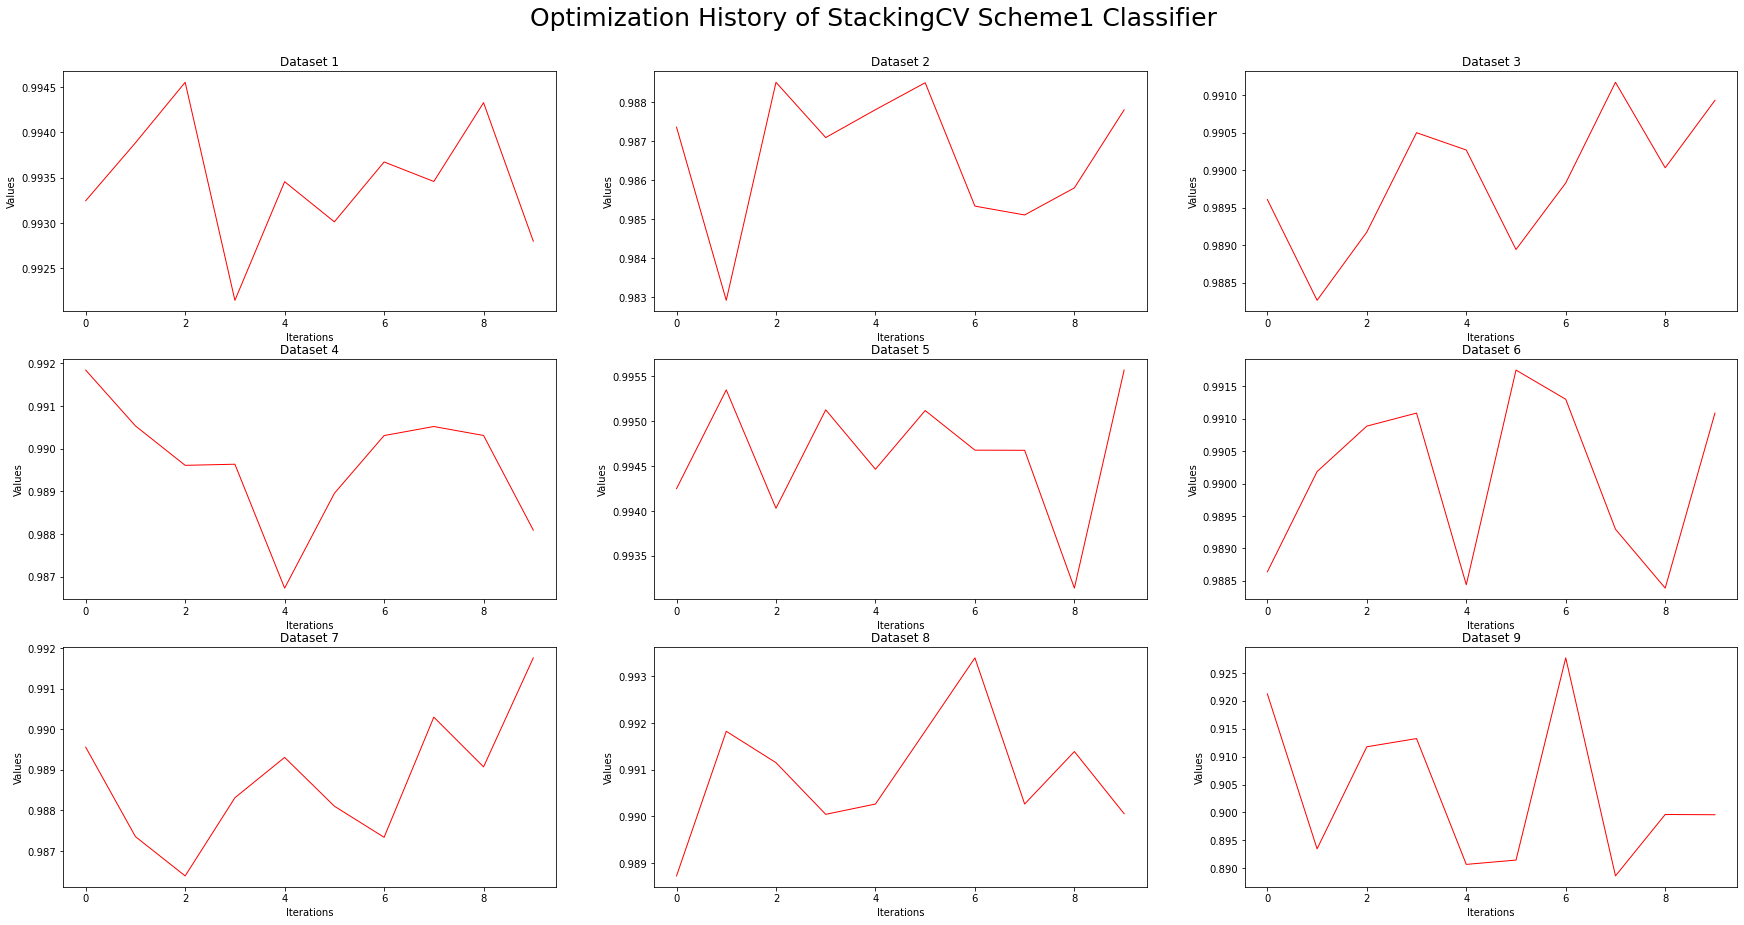

In [46]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'StackingCV Scheme1 Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

### Feature Importance of Meta Learner

        N       X       L       C       R     GB
N     inf   -0.50   -0.50   -0.50   -0.50  45.67
X   -0.50     inf  386.21  146.18  145.20  -0.50
L   -0.50  386.21     inf  184.86  171.92  -0.50
C   -0.50  146.18  184.86     inf  110.09  -0.50
R   -0.50  145.20  171.92  110.09     inf  -0.50
GB  45.67   -0.50   -0.50   -0.50   -0.50    inf


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:33:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 3020, number of negative: 3040
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6060, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498350 -> initscore=-0.006601
[LightGBM] [Info] Start training from score -0.006601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


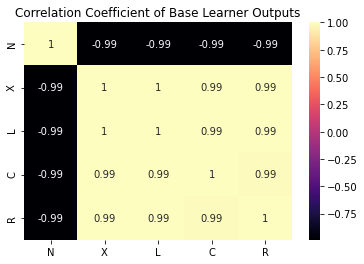

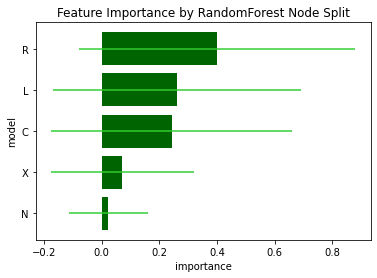

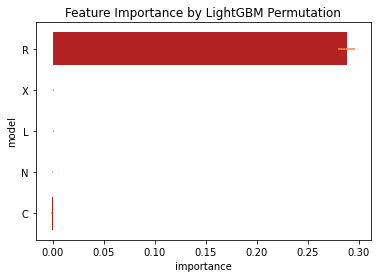

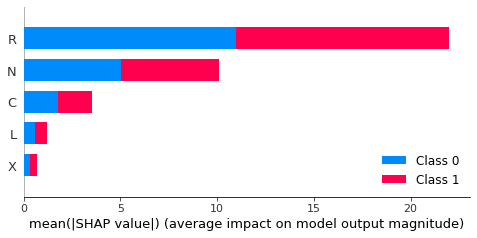

,GLM,forest,permutation,SHAP,total_rank
R,1.0,1.0,1.0,1.0,1.0
L,4.0,2.0,3.0,4.0,2.5
N,2.0,5.0,4.0,2.0,2.5
C,3.0,3.0,5.0,3.0,4.0
X,5.0,4.0,2.0,5.0,5.0


In [9]:
target_set = 5
rank_importance(train_firstC[f'set{target_set}'], mode = 'C')

### Classifier

0it [00:00, ?it/s]


 Dataset1:
Precision: 0.001952807160292921 
Recall: 0.23529411764705882 
Aging Rate: 0.12631297662850213

 Dataset2:
Precision: 0.0011998628728145354 
Recall: 0.4117647058823529 
Aging Rate: 0.3597607350613579

 Dataset3:
Precision: 0.0008262600465710208 
Recall: 0.21568627450980393 
Aging Rate: 0.2736541347201381

 Dataset4:
Precision: 0.001335509719542959 
Recall: 0.17647058823529413 
Aging Rate: 0.13852288844580568

 Dataset5:
Precision: 0.001254075746175069 
Recall: 0.09803921568627451 
Aging Rate: 0.08195440810705255

 Dataset6:
Precision: 0.0012071291628204218 
Recall: 0.3333333333333333 
Aging Rate: 0.2894817981870131

 Dataset7:
Precision: 0.0013053410203415642 
Recall: 0.23529411764705882 
Aging Rate: 0.18896585746880717

 Dataset8:
Precision: 0.001273074474856779 
Recall: 0.0392156862745098 
Aging Rate: 0.032292544553844886

 Dataset9:
Precision: 0.0010236724248240564 
Recall: 0.1568627450980392 
Aging Rate: 0.16064050648523093


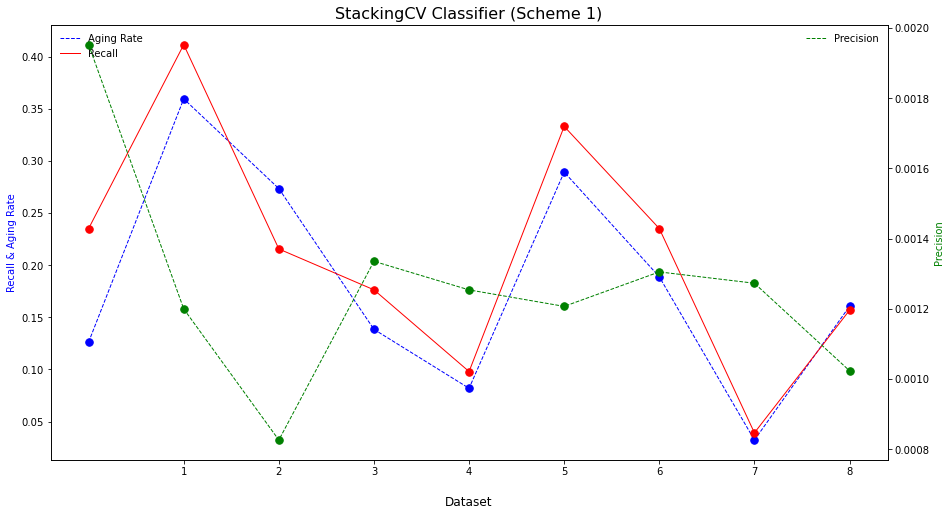

In [47]:
table_setC, coefC = runall_LR(train_firstC_x, test_firstC_x, train_firstC_y, test_firstC_y, best_paramC)
line_chart(table_setC, title = 'StackingCV Classifier (Scheme 1)')

In [48]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,12.0,6133.0,39.0,42465.0,0.001953,0.235294,0.126313,1.862787,0.001937,0.247481
dataset2,1.000000,2997.0,2997.0,21.0,17481.0,30.0,31117.0,0.001200,0.411765,0.359761,1.144552,0.001196,0.314148
dataset3,1.000000,3033.0,3033.0,11.0,13302.0,40.0,35296.0,0.000826,0.215686,0.273654,0.788171,0.000823,0.000000
dataset4,1.000000,3038.0,3038.0,9.0,6730.0,42.0,41868.0,0.001336,0.176471,0.138523,1.273945,0.001325,0.144973
dataset5,1.006623,3040.0,3020.0,5.0,3982.0,46.0,44616.0,0.001254,0.098039,0.081954,1.196265,0.001238,0.077133
dataset6,1.016722,3040.0,2990.0,17.0,14066.0,34.0,34532.0,0.001207,0.333333,0.289482,1.151483,0.001203,0.255386
dataset7,1.099458,3040.0,2765.0,12.0,9181.0,39.0,39417.0,0.001305,0.235294,0.188966,1.245167,0.001298,0.190301
dataset8,1.000000,3040.0,3040.0,2.0,1569.0,49.0,47029.0,0.001273,0.039216,0.032293,1.214388,0.001233,0.031176
dataset9,10.000000,3040.0,304.0,8.0,7807.0,43.0,40791.0,0.001024,0.156863,0.160641,0.976483,0.001017,0.000000


### Export

In [49]:
savedate = '20220315'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'StackingCV1_XLCR'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'StackingCV1_XLCR')